## TOC:
* [1 Load Data](#load-data)
    * 1.1 Read Information from Metadata
    * 1.2 Load Learn and Test Files
    
* [2 Exploration and Preparation](#exploration-and-preparation)
    * 2.1 Check Imbalance
    * 2.2 Value Summary
    * 2.3 Visualization of Categorical Data
    * 2.4 Visualization of Continuous Data
    * 2.5 Feature Processing
    
* [3 Build Model](#build-model)
    * 3.1 Logistic Regression
    * 3.2 Decision Tree
    * 3.3 Random Forest
    * 3.4 Ensembled Model
    

### Most Challenging Part

I think the most challenge part would be precessing features. Since the data is not "perfect", we have to find and decide how to deal with missing values and/ro how to do feature engineering. 

Based on the observation we made from summarizing and visualizing data, although I only preformed some easier solutions, there are so many things we can do to try to make the model beter. For instance, for continuous variable, we could also run a box-cox transformation to make the distribution more normal, and/or try polynomial features which maybe helpful for linear models.


### Insights

The importance of each feature varies among different models, however, all of them show that education, sex, major ocupation are important features which also intuitively make sense. 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

np.set_printoptions(precision=3, suppress=True)
% matplotlib inline
plt.rcParams["figure.dpi"] = 200
plt.style.use(['fivethirtyeight'])

## Load Data <a class="anchor" id="load-data"></a>

### 1.1 Read Information from Metadata

In [2]:
# load feature names from metadata file
col_info = pd.read_csv(os.path.join('us_census_full', 'census_income_metadata.txt'), header=None, 
                   skiprows=142, nrows=42, sep=":")
col_info.columns = ['col_name', 'col_detail']
col_info['col_type'] = col_info.col_detail.apply(lambda x: 'continuous' if 'continuous' in x else 'categorical')


col_info = col_info[~col_info.col_detail.str.contains('ignore')]

In [3]:
col_info

col_name  \
0                                          age   
1                              class of worker   
2                     detailed industry recode   
3                   detailed occupation recode   
4                                    education   
5                                wage per hour   
6                   enroll in edu inst last wk   
7                                 marital stat   
8                          major industry code   
9                        major occupation code   
10                                        race   
11                             hispanic origin   
12                                         sex   
13                     member of a labor union   
14                     reason for unemployment   
15           full or part time employment stat   
16                               capital gains   
17                              capital losses   
18                       dividends from stocks   
19                              tax filer stat   
20                region of previous residence   
21                 state of previous residence   
22          detailed household and family stat   
23     detailed household summary in household   
25                             instance weight   
26                migration code-change in msa   
27                migration code-change in reg   
28              migration code-move within reg   
29               live in this house 1 year ago   
30               migration prev res in sunbelt   
31             num persons worked for employer   
32                     family members under 18   
33                     country of birth father   
34                     country of birth mother   
35                       country of birth self   
36                                 citizenship   
37               own business or self employed   
38  fill inc questionnaire for veteran's admin   
39                           veterans benefits   
40                        weeks worked in year   
41                                        year   

                                           col_detail     col_type  
0                                         continuous.   continuous  
1    Not in universe, Federal government, Local go...  categorical  
2    0, 40, 44, 2, 43, 47, 48, 1, 11, 19, 24, 25, ...  categorical  
3    0, 12, 31, 44, 19, 32, 10, 23, 26, 28, 29, 42...  categorical  
4    Children, 7th and 8th grade, 9th grade, 10th ...  categorical  
5                                         continuous.   continuous  
6    Not in universe, High school, College or univ...  categorical  
7    Never married, Married-civilian spouse presen...  categorical  
8    Not in universe or children, Entertainment, S...  categorical  
9    Not in universe, Professional specialty, Othe...  categorical  
10   White, Black, Other, Amer Indian Aleut or Esk...  categorical  
11   Mexican (Mexicano), Mexican-American, Puerto ...  categorical  
12                                      Female, Male.  categorical  
13                          Not in universe, No, Yes.  categorical  
14   Not in universe, Re-entrant, Job loser - on l...  categorical  
15   Children or Armed Forces, Full-time schedules...  categorical  
16                                        continuous.   continuous  
17                                        continuous.   continuous  
18                                        continuous.   continuous  
19   Nonfiler, Joint one under 65 & one 65+, Joint...  categorical  
20   Not in universe, South, Northeast, West, Midw...  categorical  
21   Not in universe, Utah, Michigan, North Caroli...  categorical  
22   Child <18 never marr not in subfamily, Other ...  categorical  
23   Child under 18 never married, Other relative ...  categorical  
25                                        continuous.   continuous  
26   Not in universe, Nonmover, MSA to MSA, NonMSA...  categorical  
27   Not in universe, Nonmover, Same county, Diffe...  categorical  
28   

In [4]:
# get list of categorical features and list of continuous features
categorical = col_info.col_name[col_info.col_type == 'categorical']
continuous = col_info.col_name[col_info.col_type == 'continuous']

### 1.2 Load Learn and Test Files

In [5]:
def load_data(file_name):
    # load learn file
    data = pd.read_csv(os.path.join('us_census_full', file_name), header=None, na_values=[' ?'])
    data.columns = col_info.col_name.tolist() + ['above 50k']

    # Since it is calssification problem, according to the document, we should not use 'instance weight'
    data = data.drop('instance weight', axis=1, inplace=False)
    data['above 50k'] = data['above 50k'].replace({' - 50000.': 0,' 50000+.': 1})
    return data

In [6]:
data_train = load_data('census_income_learn.csv')
data_test = load_data('census_income_test.csv')

## Exploration and Preparation <a class="anchor" id="exploration-and-preparation"></a>

In [7]:
categorical_list = categorical.tolist()
continuous_list = continuous[continuous!='instance weight'].tolist() # ignore 'instance weight'

### 2.1 Check Imbalance
- The target is very imbalanced: over 90% data belong to a single class, this tells me that accuracy is not a good measurement for model.

In [8]:
data_train['above 50k'].value_counts()/data_train.shape[0]

0    0.937942
1    0.062058
Name: above 50k, dtype: float64

### 2.2 Value Summary

In [9]:
data_train.shape

(199523, 41)

In [10]:
pd.concat([data_train[categorical_list+continuous_list].apply(lambda x: sum(x.isnull())).rename("num_missing"),
          data_train[categorical_list+continuous_list].apply(lambda x: sum(x.str.contains('Not in universe'))).rename("num_niu"),
          data_train[categorical_list+continuous_list].apply(lambda x: len(x.unique())).rename("num_unique")], axis=1)

num_missing   num_niu  num_unique
class of worker                                       0  100245.0           9
detailed industry recode                              0       NaN          52
detailed occupation recode                            0       NaN          47
education                                             0       0.0          17
enroll in edu inst last wk                            0  186943.0           3
marital stat                                          0       0.0           7
major industry code                                   0  100684.0          24
major occupation code                                 0  100684.0          15
race                                                  0       0.0           5
hispanic origin                                       0       0.0          10
sex                                                   0       0.0           2
member of a labor union                               0  180459.0           3
reason for unemployment                               0  193453.0           6
full or part time employment stat                     0       0.0           8
tax filer stat                                        0       0.0           6
region of previous residence                          0  183750.0           6
state of previous residence                         708       NaN          51
detailed household and family stat                    0       0.0          38
detailed household summary in household               0       0.0           8
migration code-change in msa                      99696       NaN          10
migration code-change in reg                      99696       NaN           9
migration code-move within reg                    99696       NaN          10
live in this house 1 year ago                         0  101212.0           3
migration prev res in sunbelt                     99696       NaN           4
family members under 18                               0  144232.0           5
country of birth father                            6713       NaN          43
country of birth mother                            6119       NaN          43
country of birth self                              3393       NaN          43
citizenship                                           0       0.0           5
own business or self employed                         0       NaN           3
fill inc questionnaire for veteran's admin            0  197539.0           3
veterans benefits                                     0       NaN           3
year                                                  0       NaN           2
age                                                   0       NaN          91
wage per hour                                         0       NaN        1240
capital gains                                         0       NaN         132
capital losses                                        0       NaN         113
dividends from stocks                                 0       NaN        1478
num persons worked for employer                       0       NaN           7
weeks worked in year                                  0       NaN          53

### 2.3 Visualization of Categorical Data

- For categorical variables, I visualized two things:
    - The count of each category (left plot)
    - The mean outcome for each category (right plot), baseline is the ratio of 'above 50k' category (0.062058)

In [11]:
def visualize_categorical(ax1, ax2, df, col, target):
    #plot counts:
    cnt = df[col].value_counts().sort_values(ascending=False)
    cnt.plot(kind='barh', ax=ax1)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Count')
    
    #plot means:
    means = df.groupby(col)[target].mean()
    means[cnt.index].plot(kind='barh', ax=ax2)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.axvline(x=0.062058, linewidth=1, color='red', linestyle='--') #baseline 
    ax2.set_xlabel('Percentage Above 50K')

/Users/lucylu/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


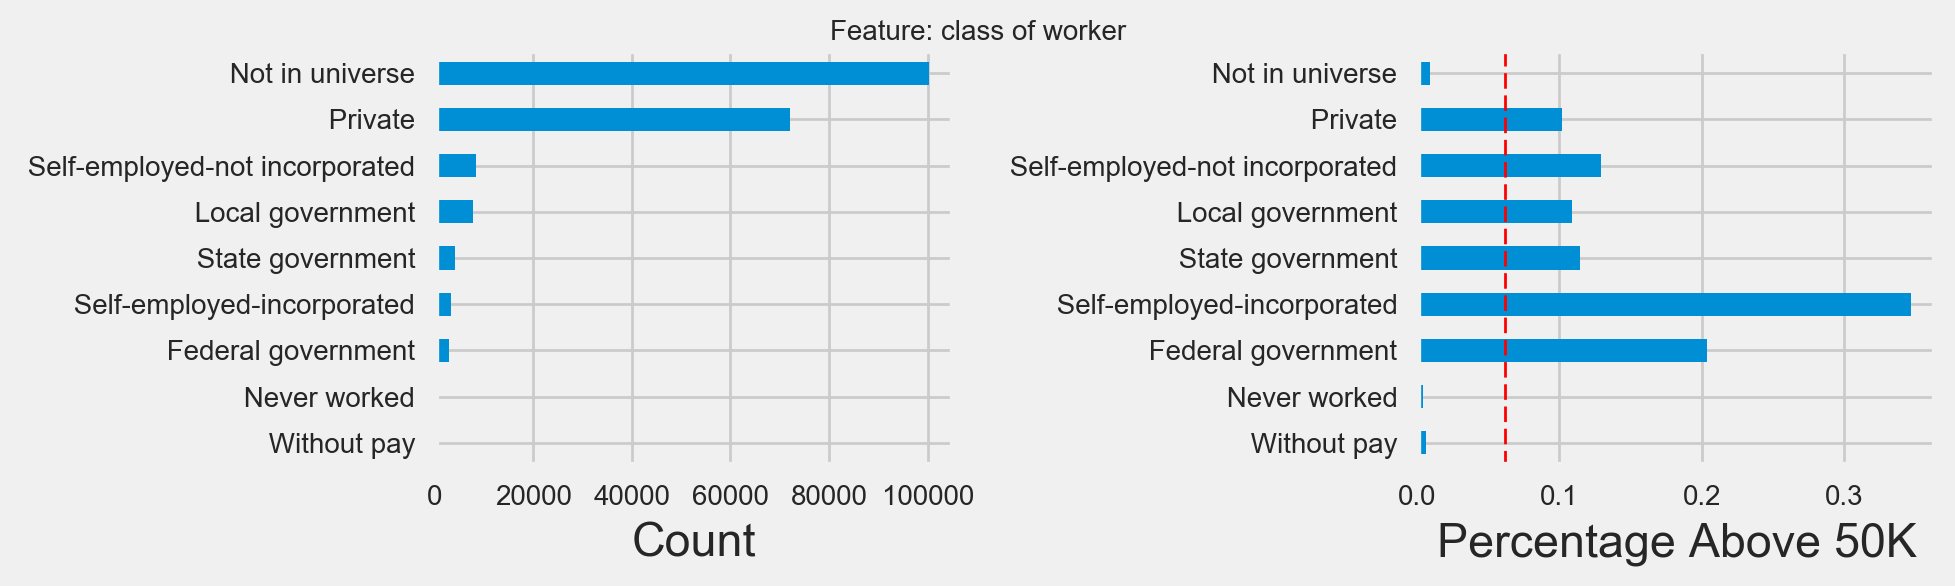

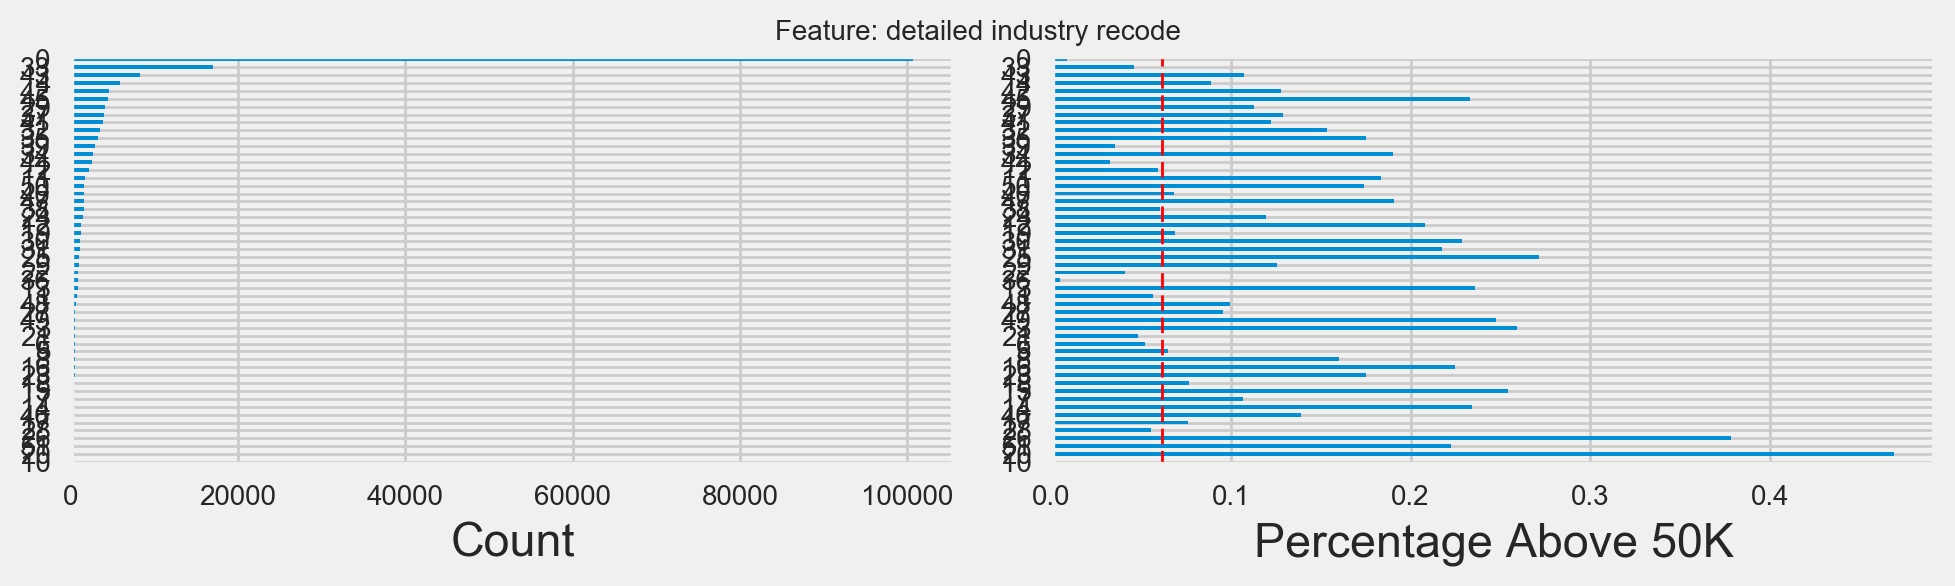

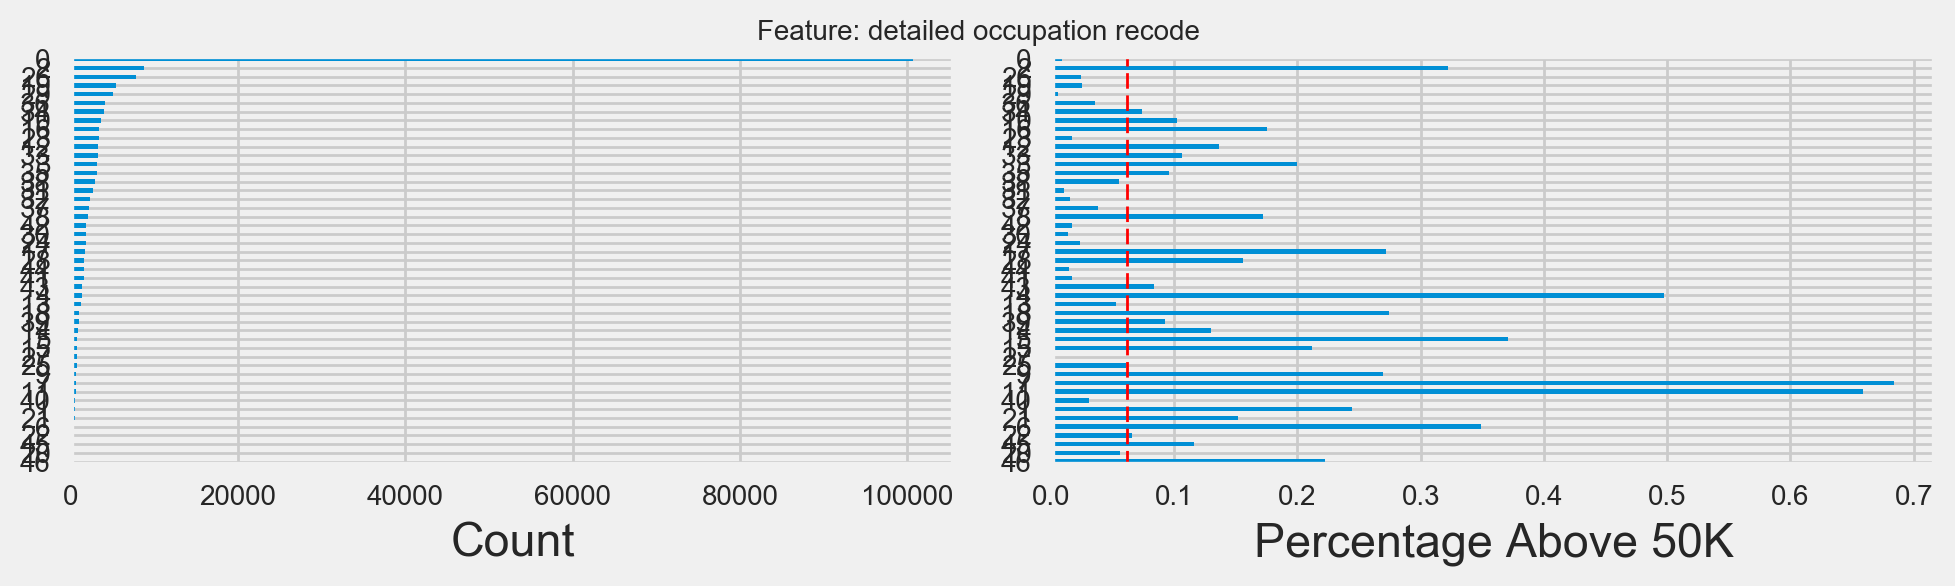

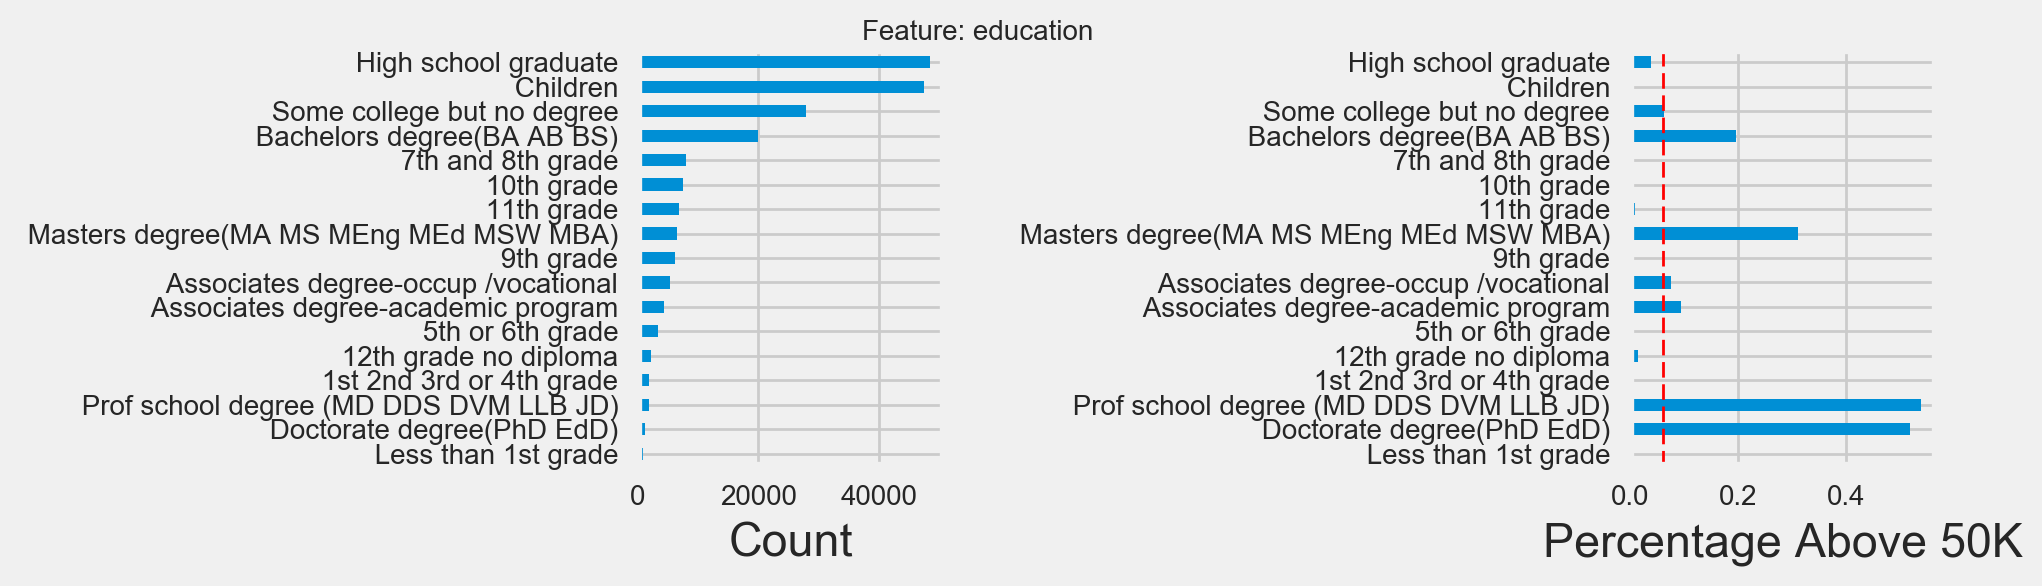

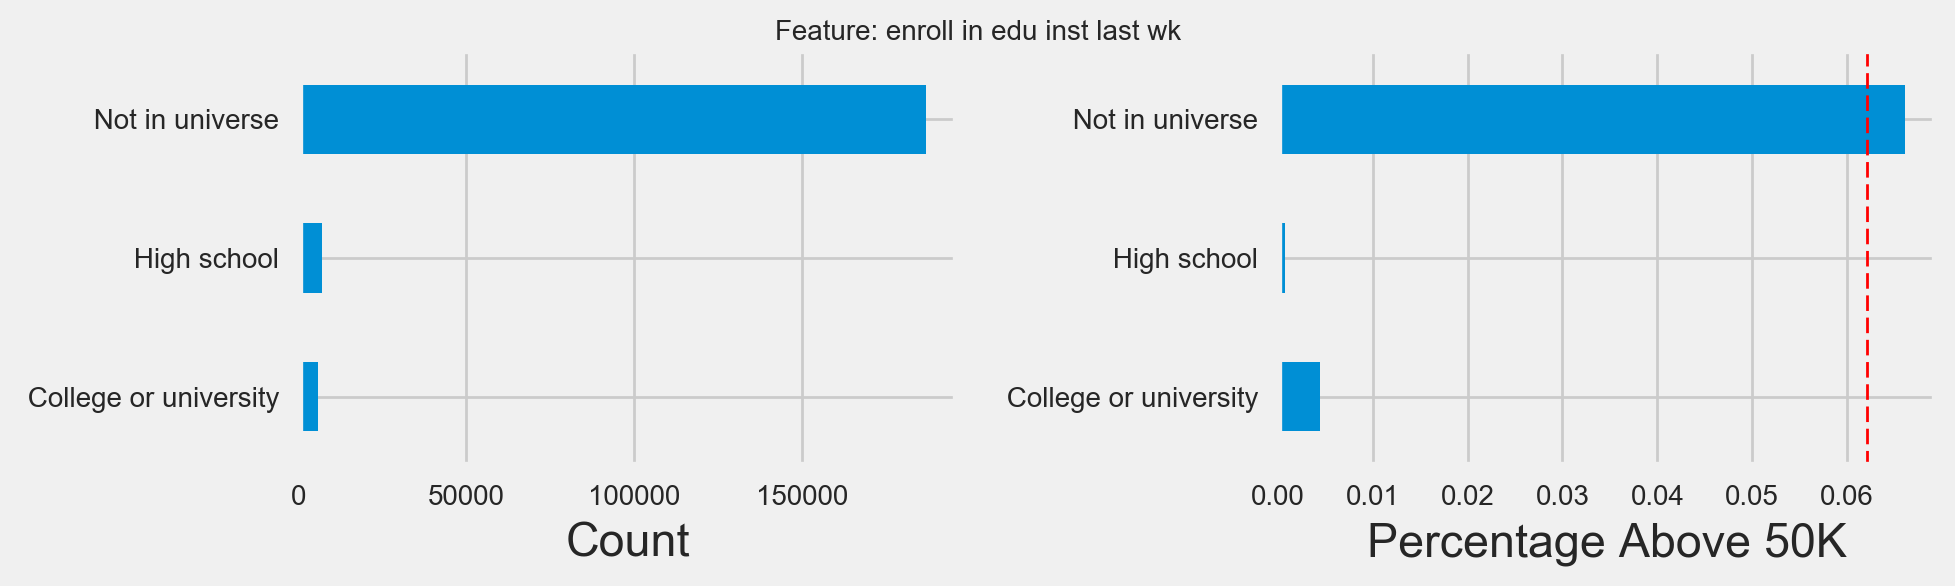

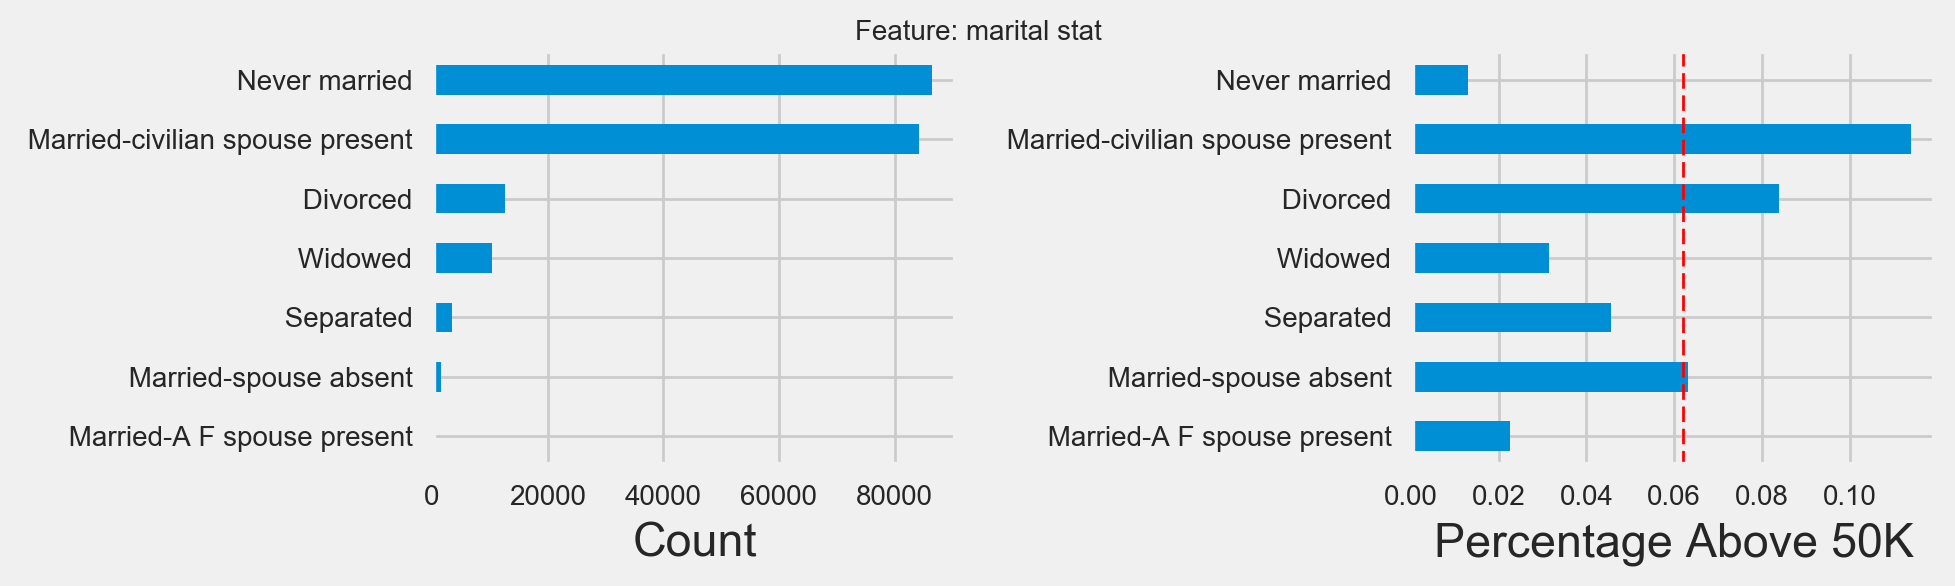

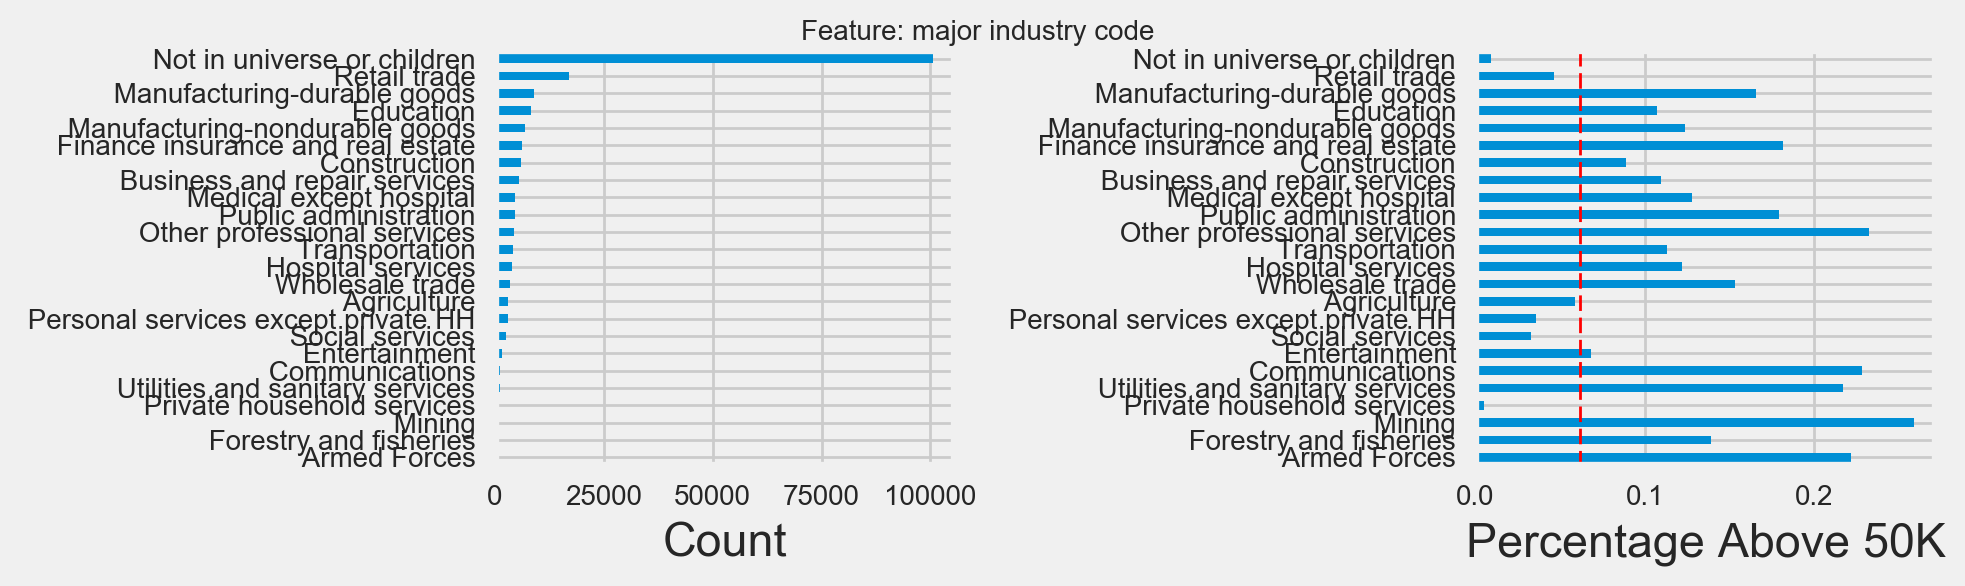

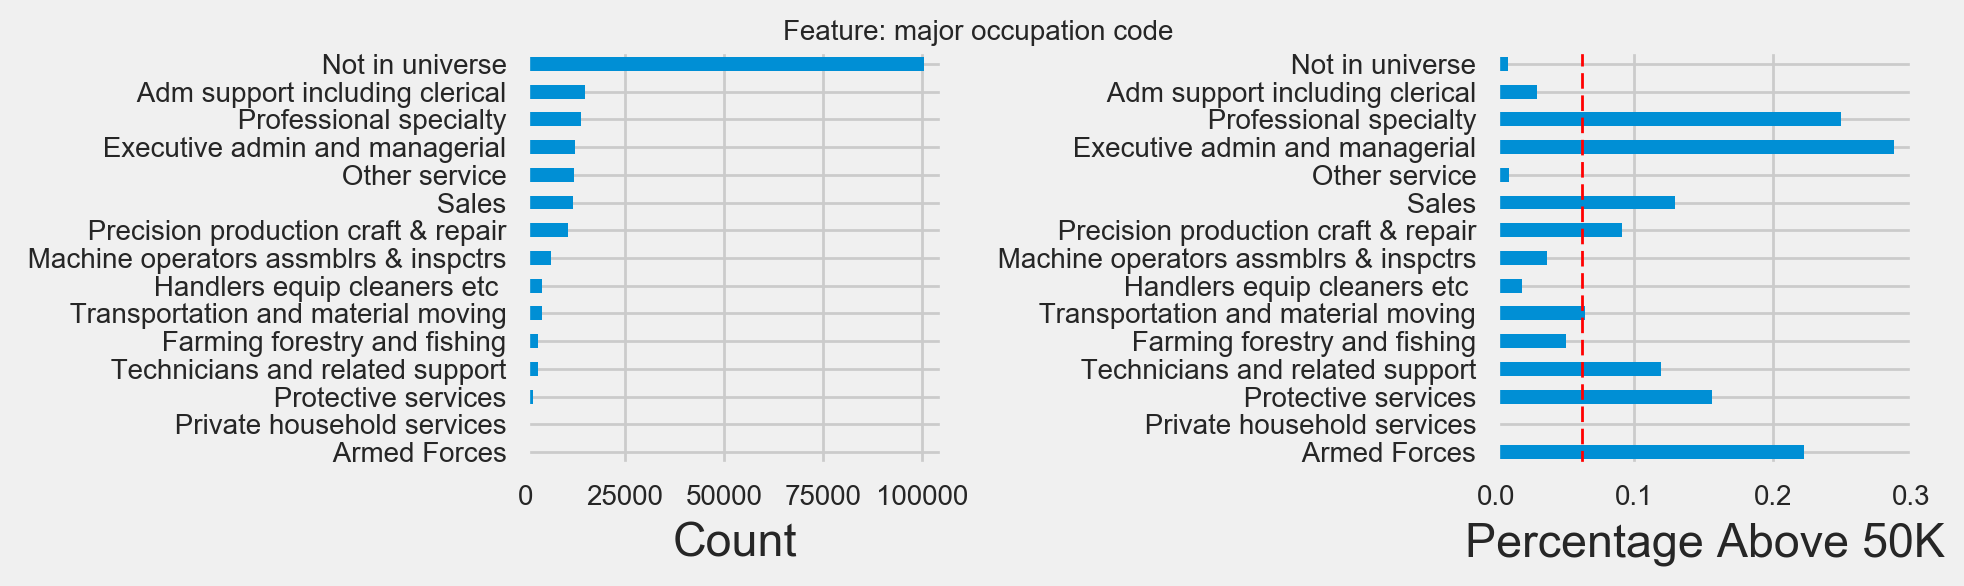

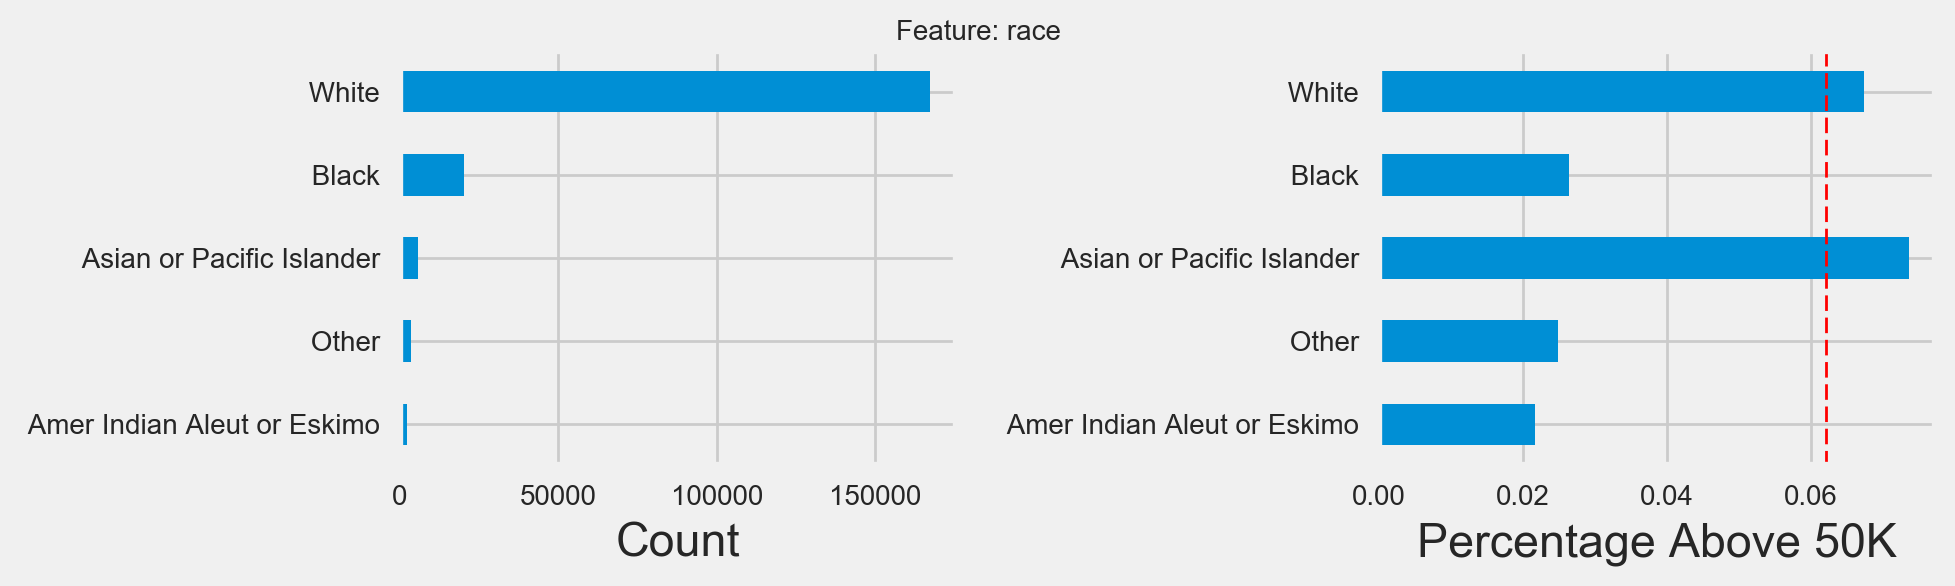

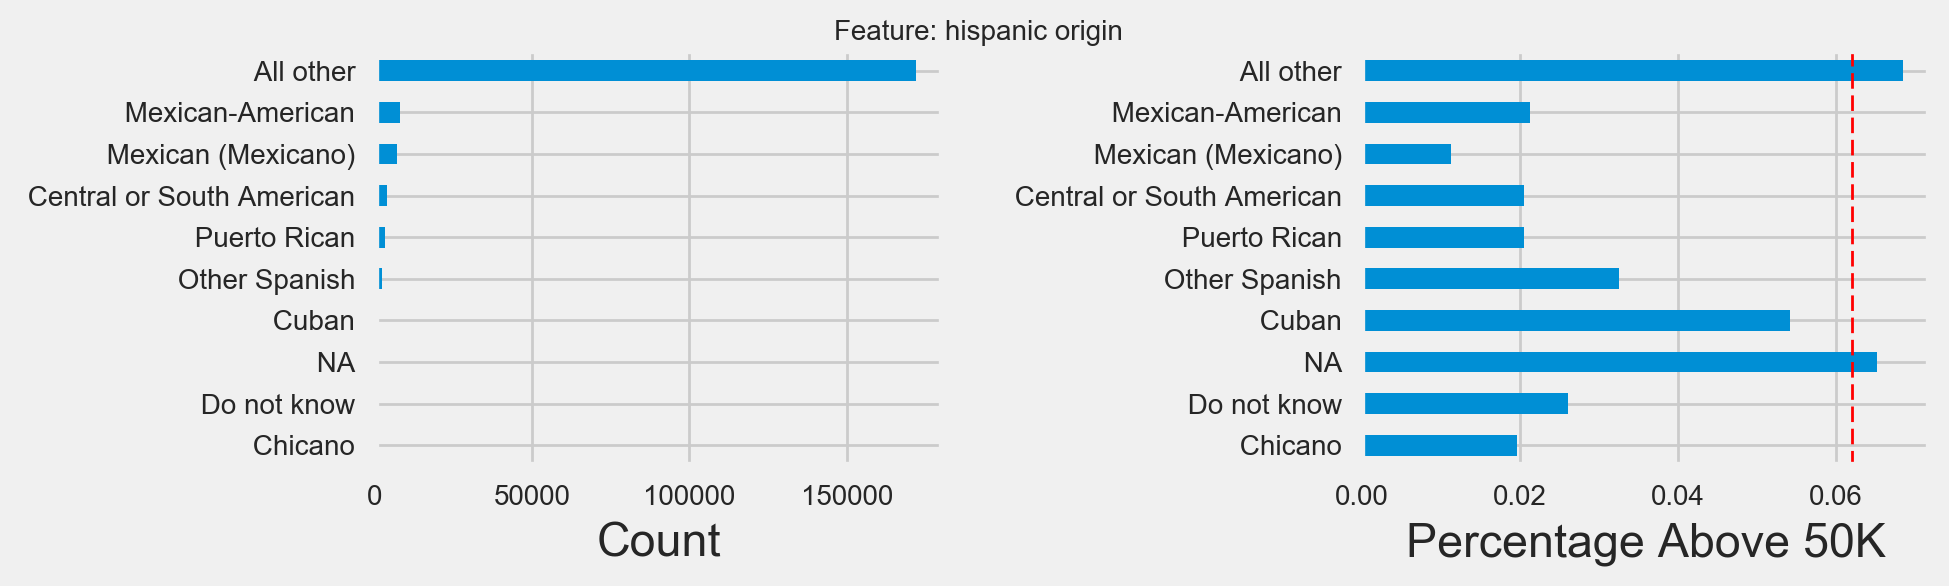

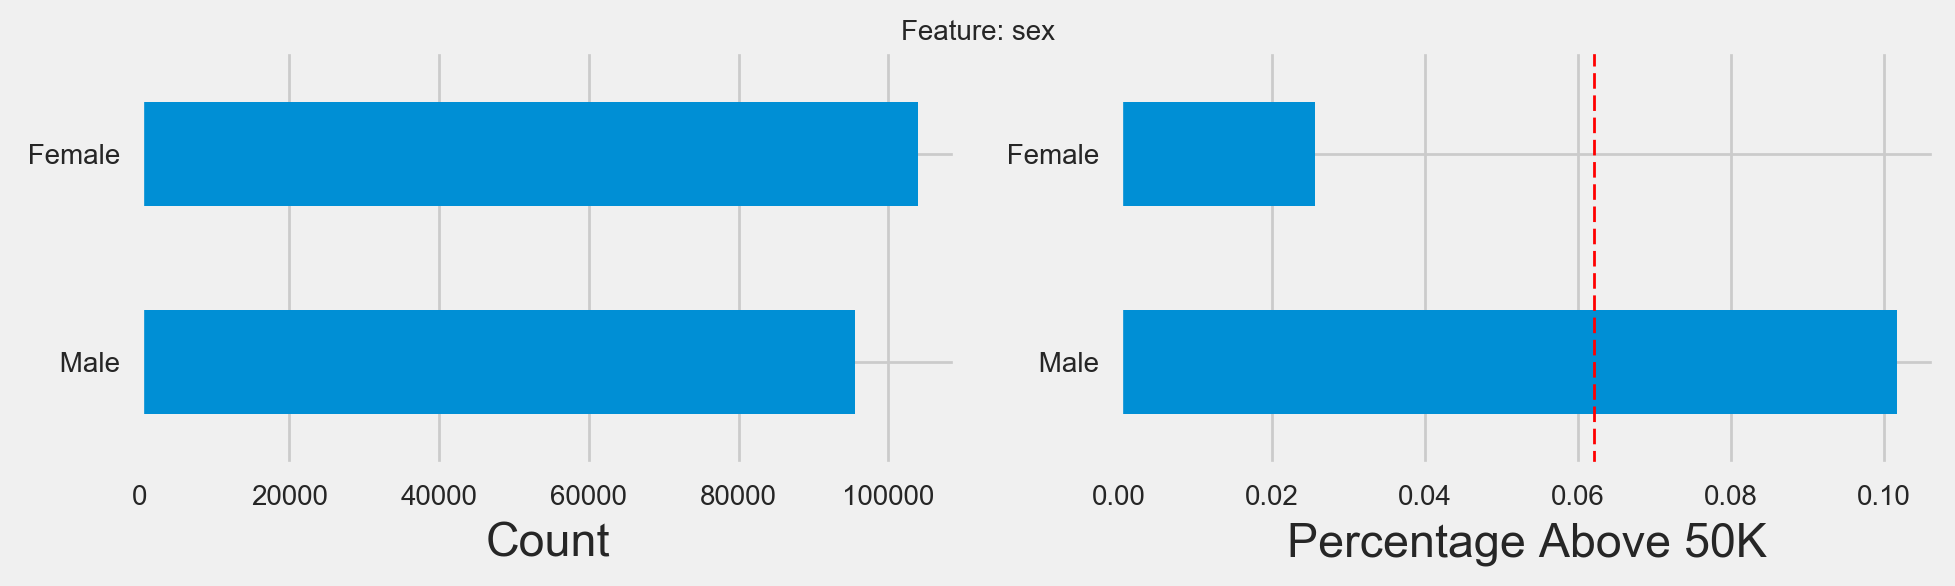

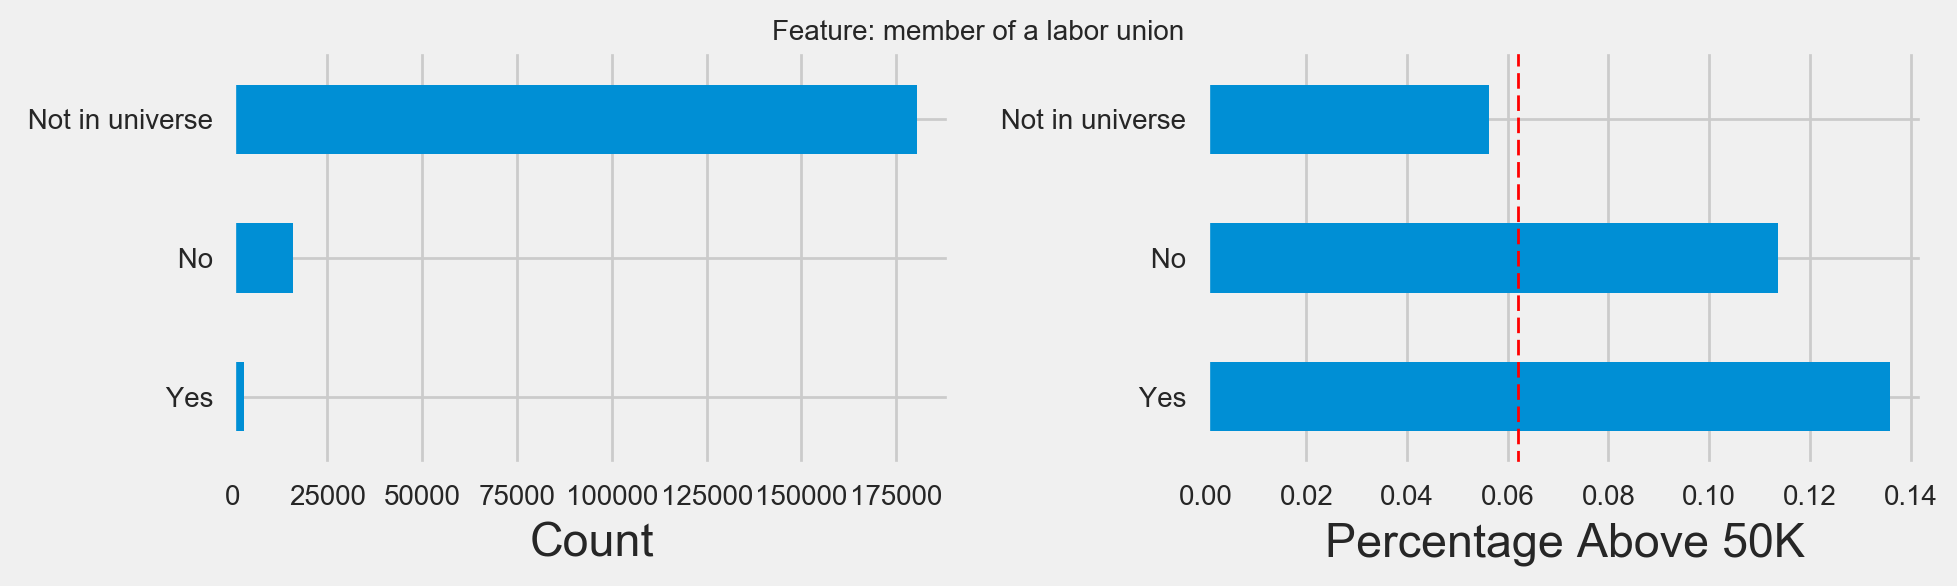

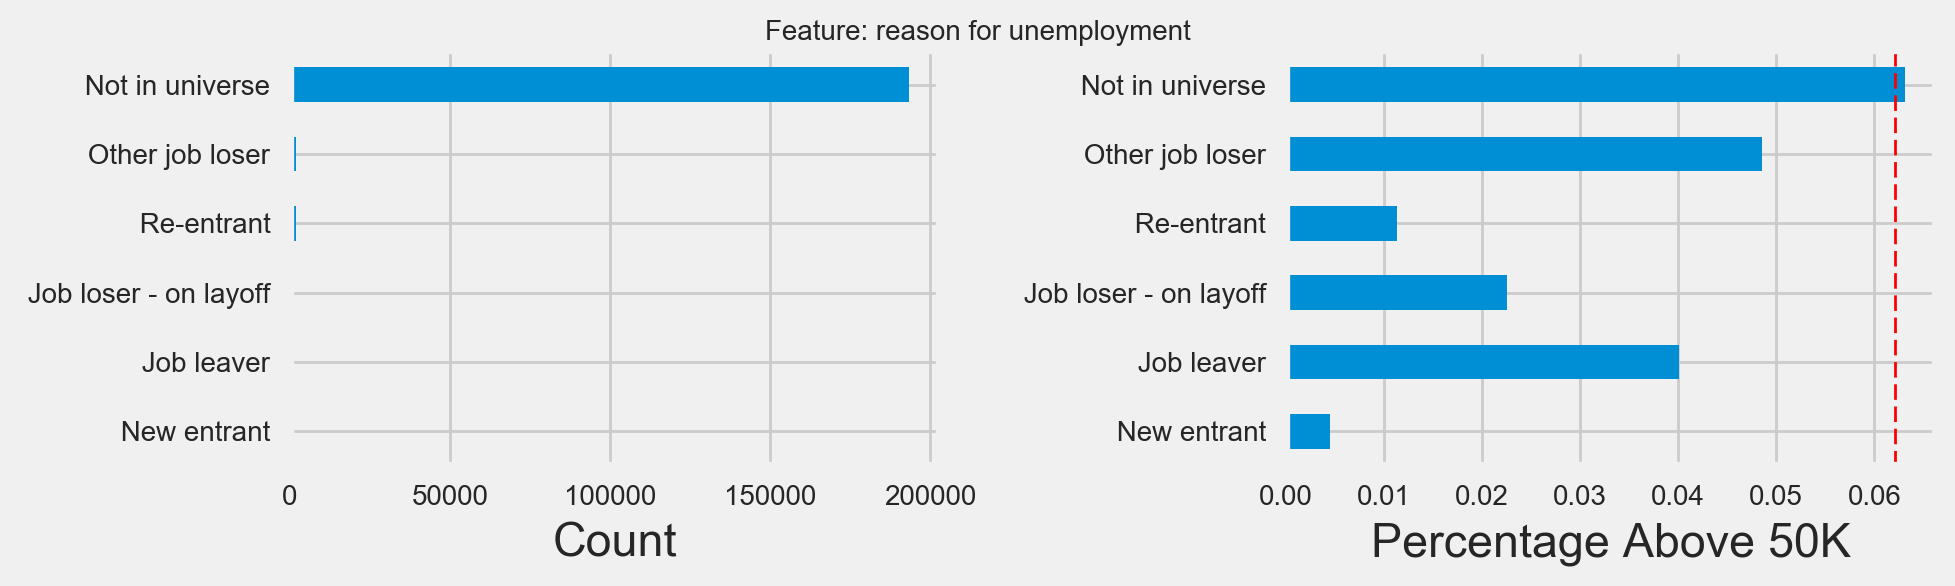

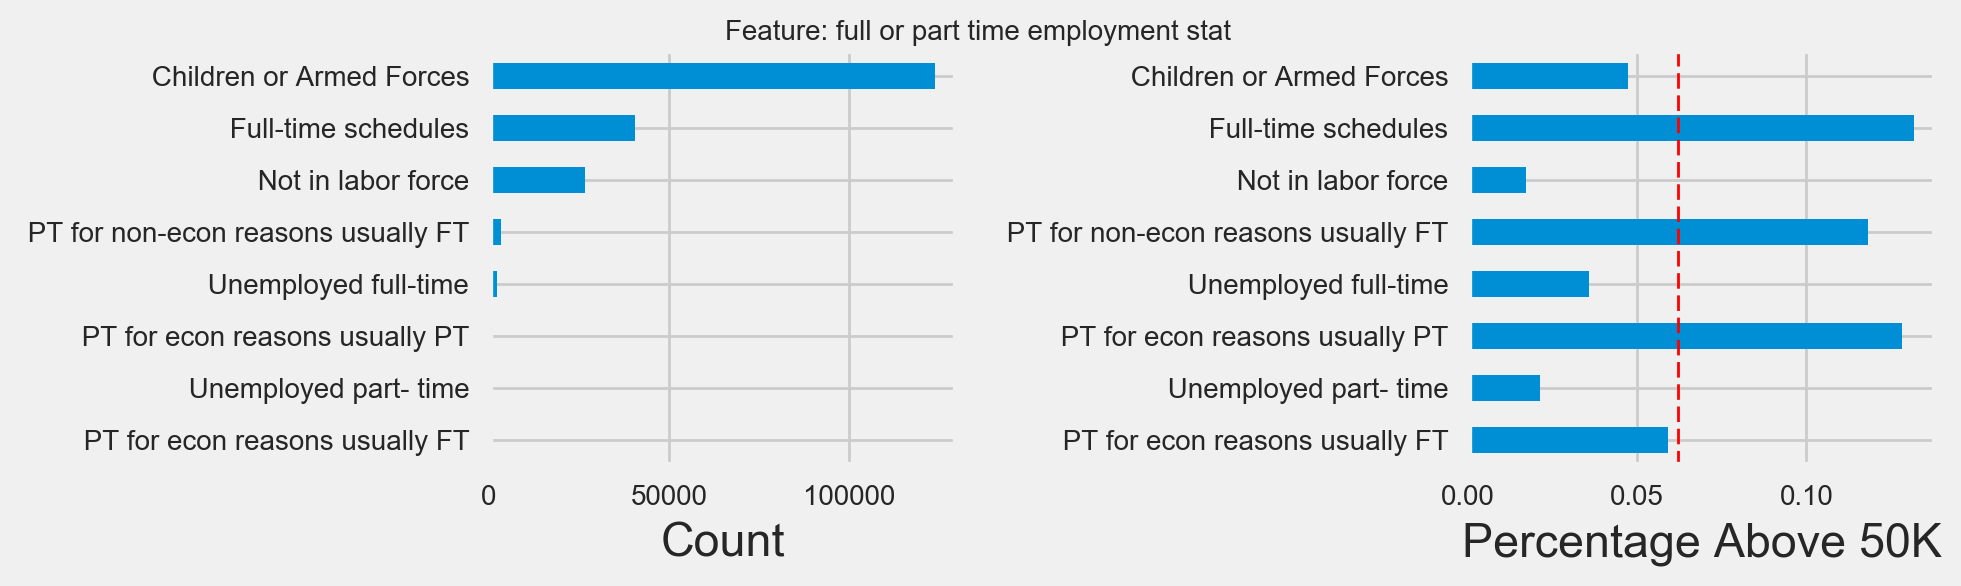

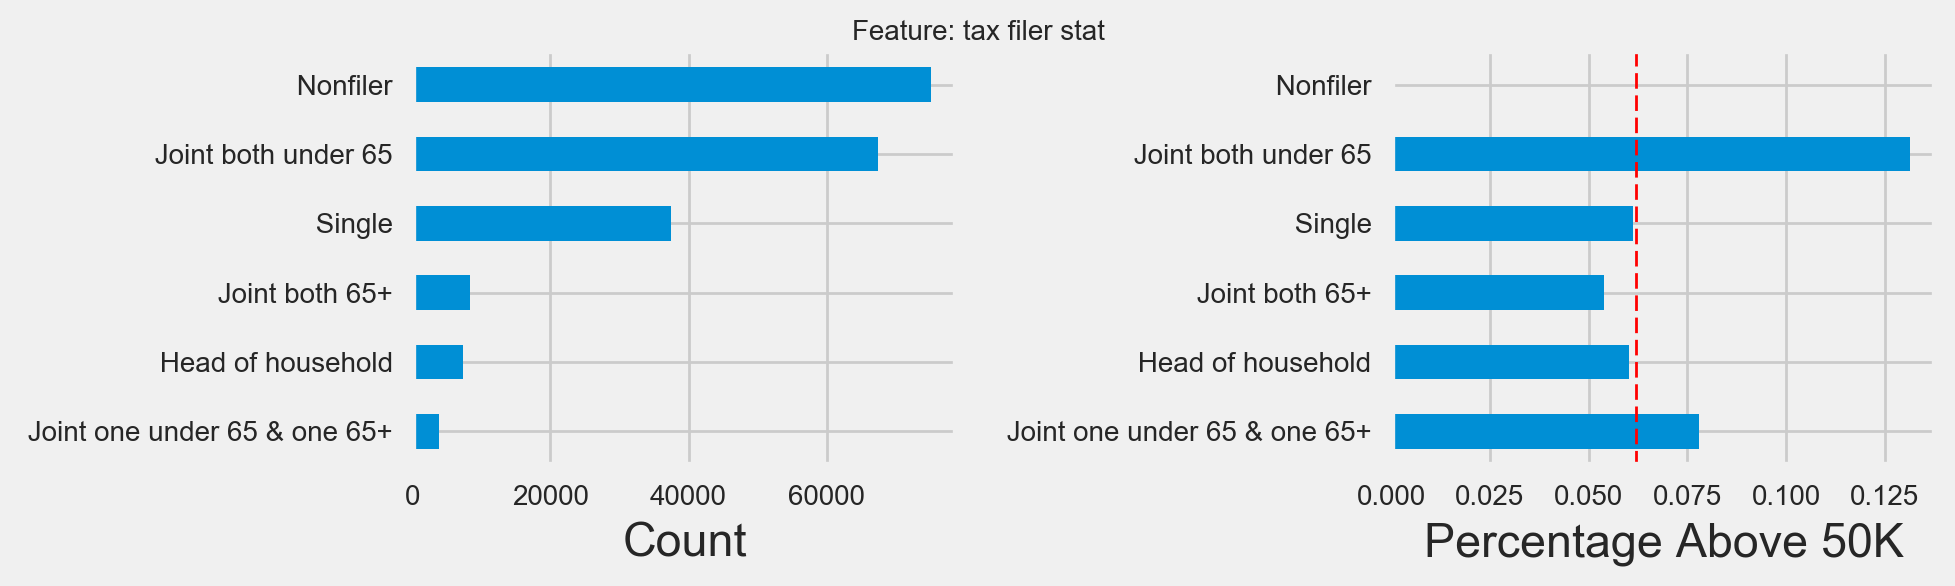

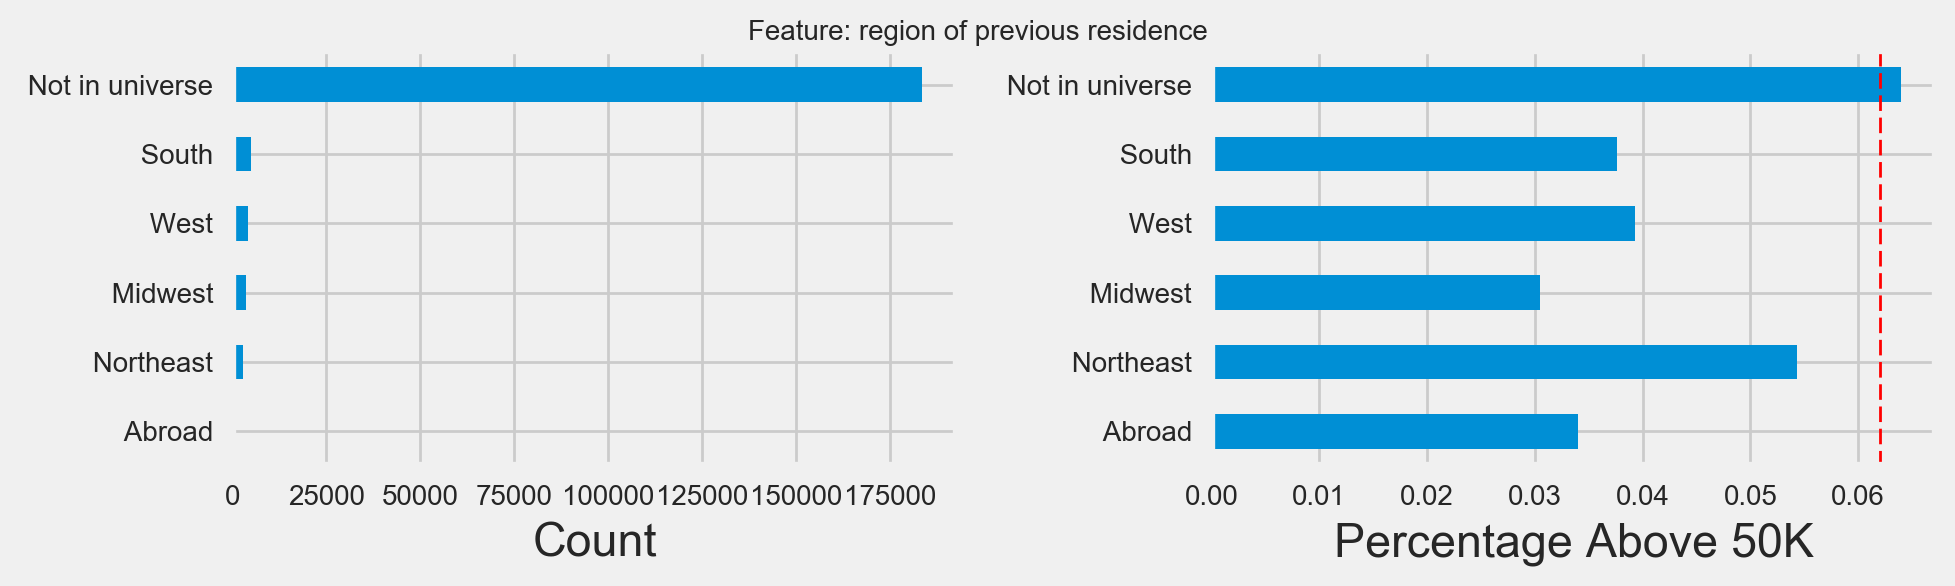

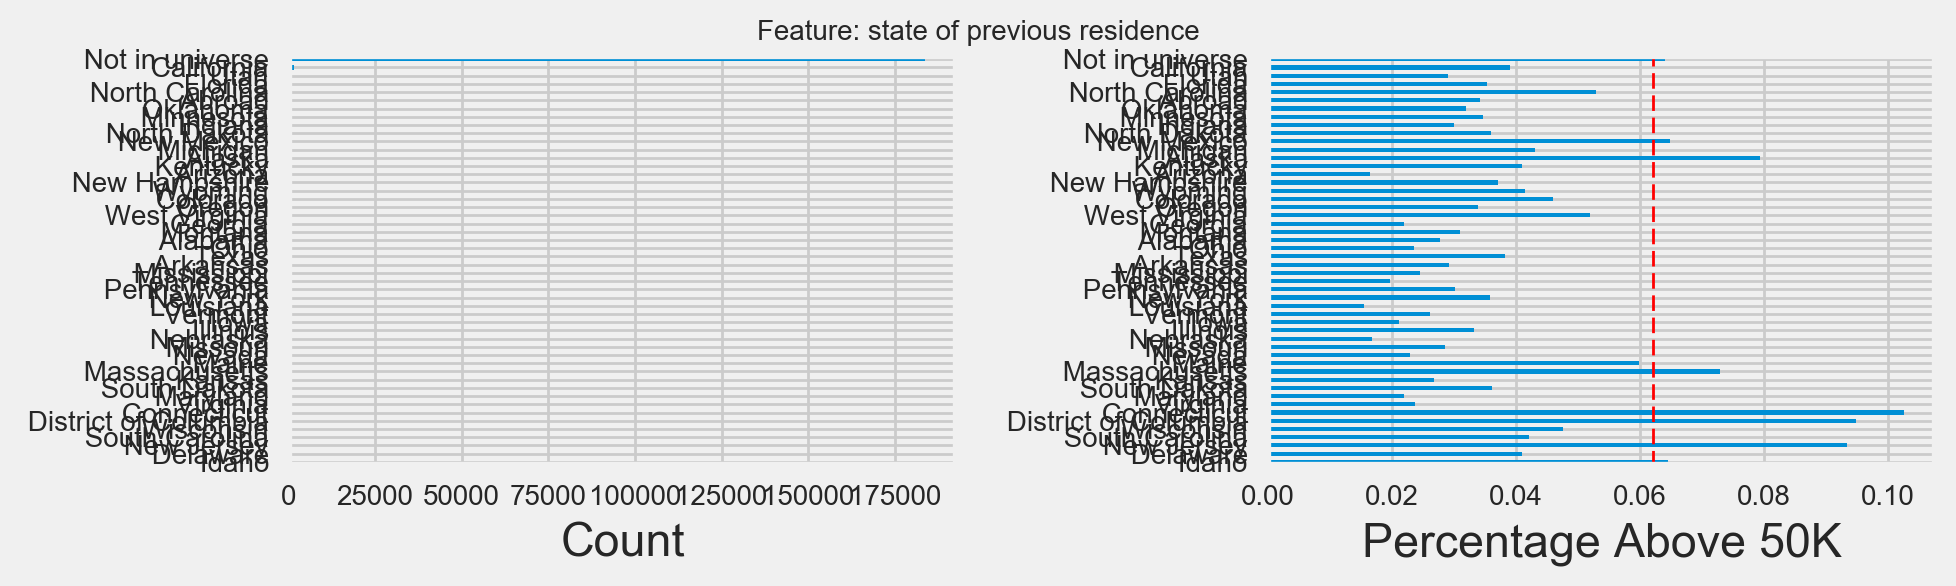

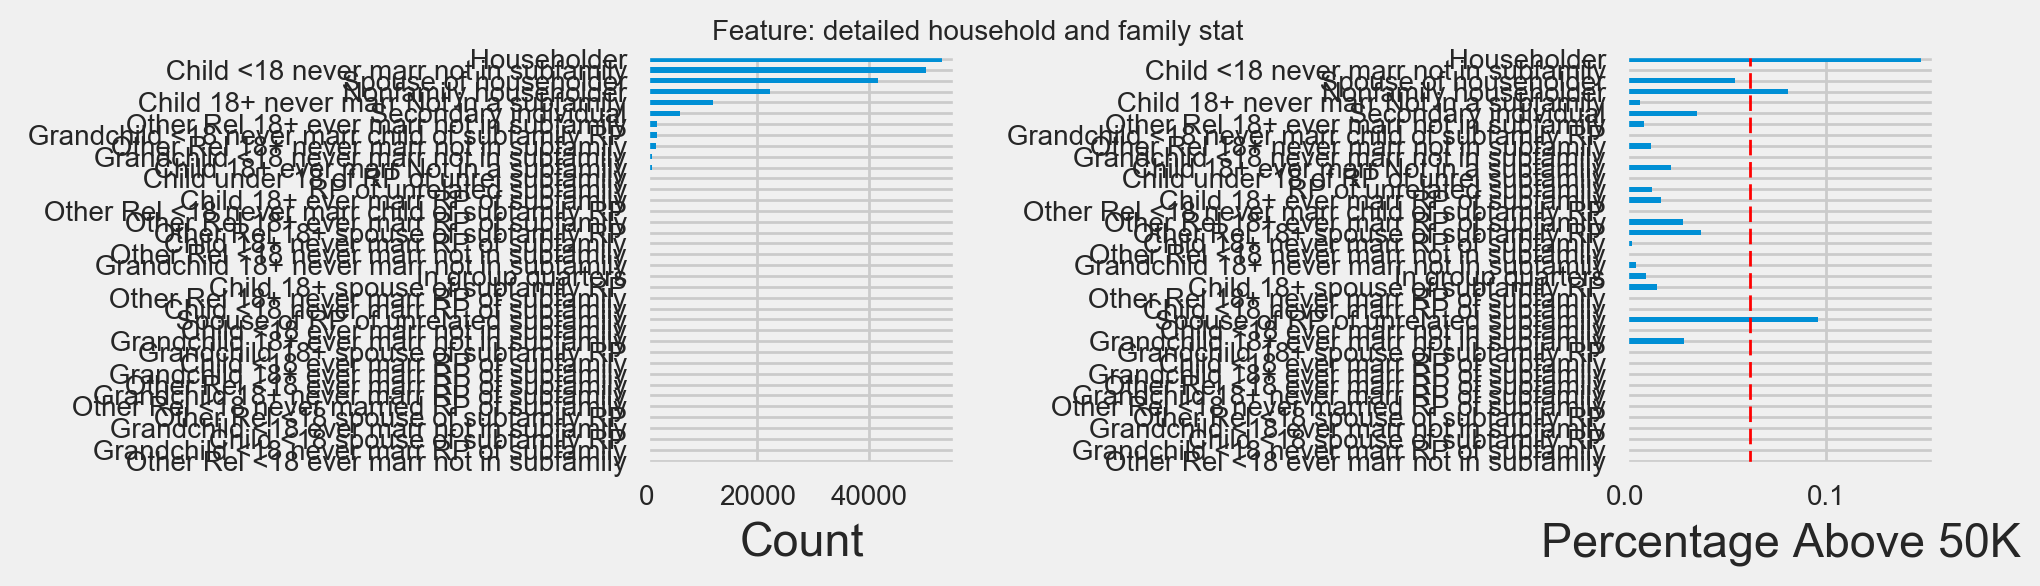

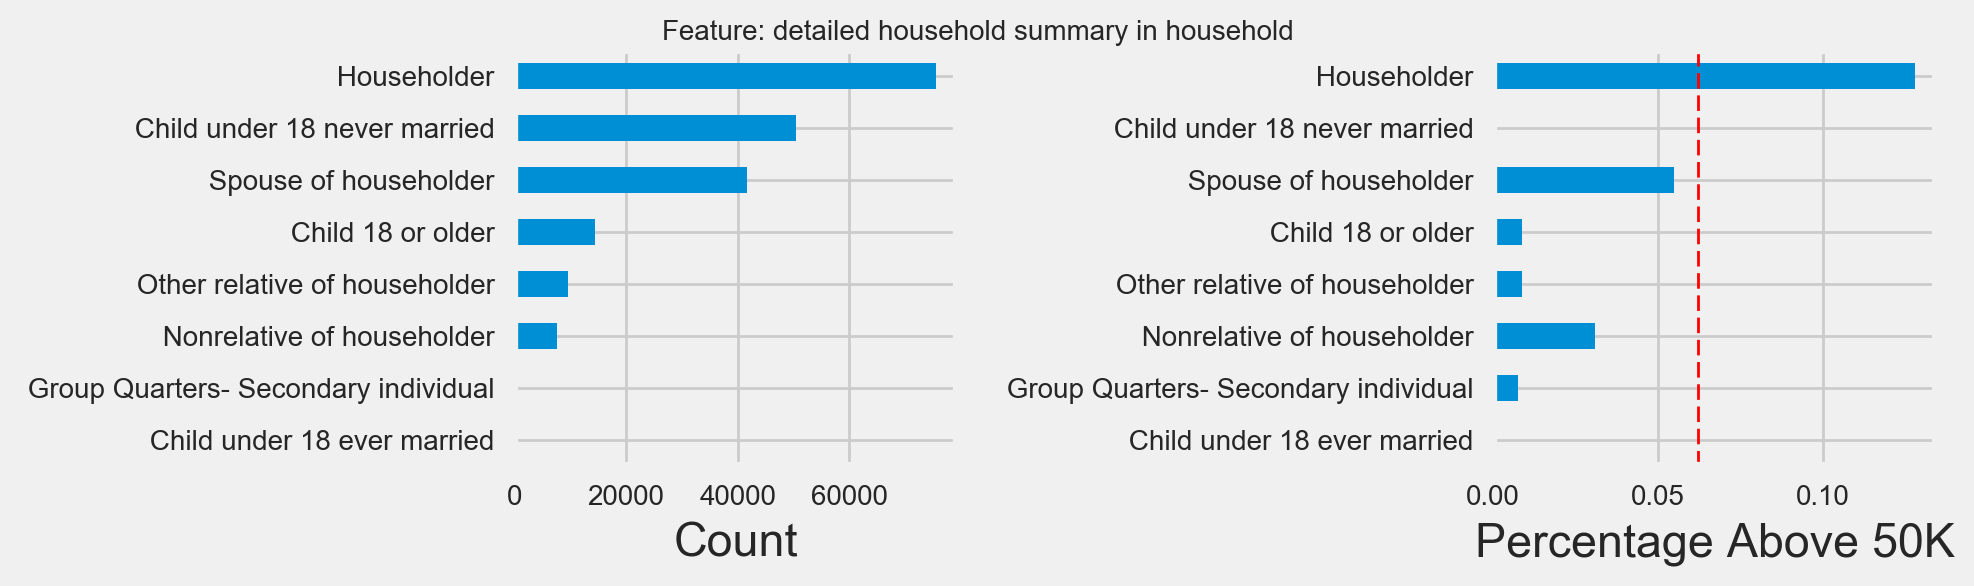

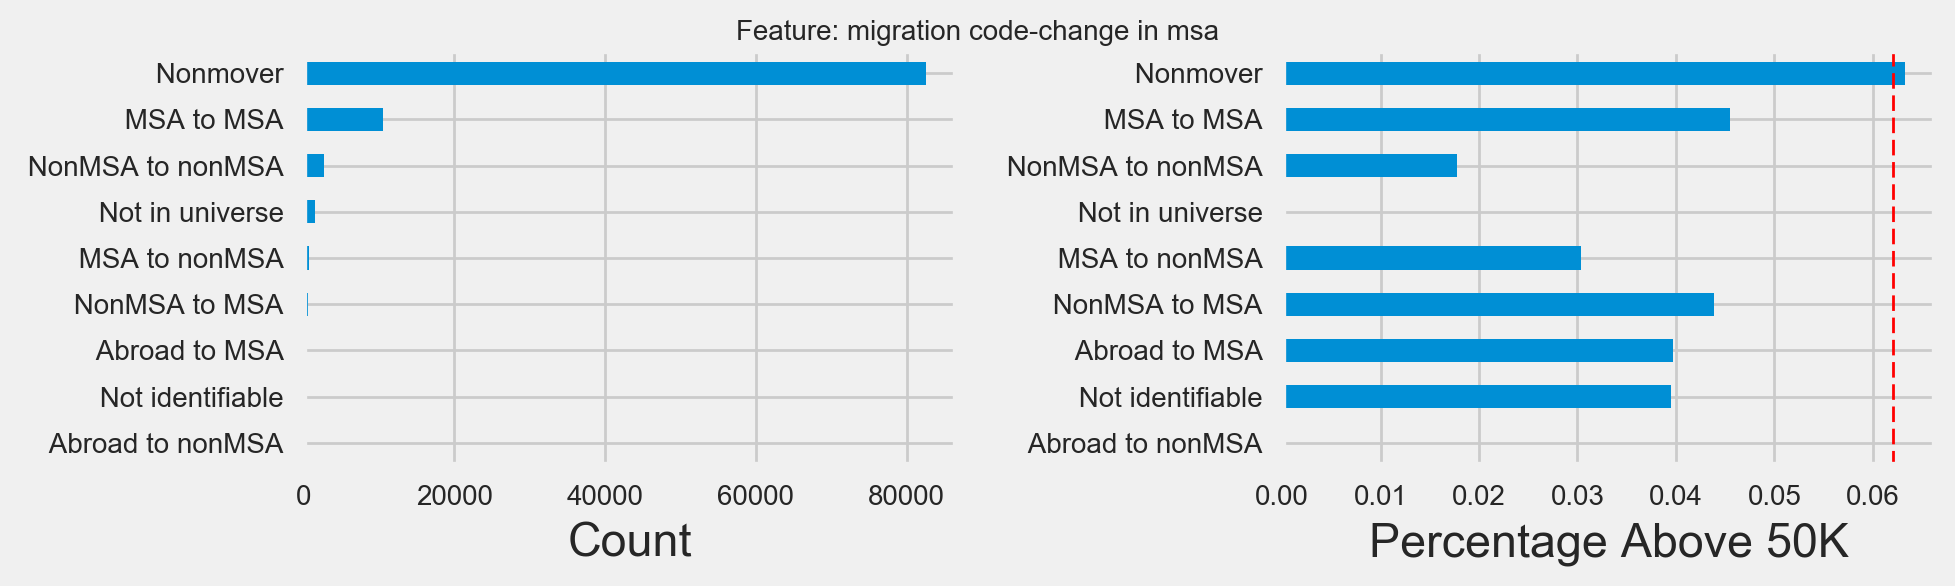

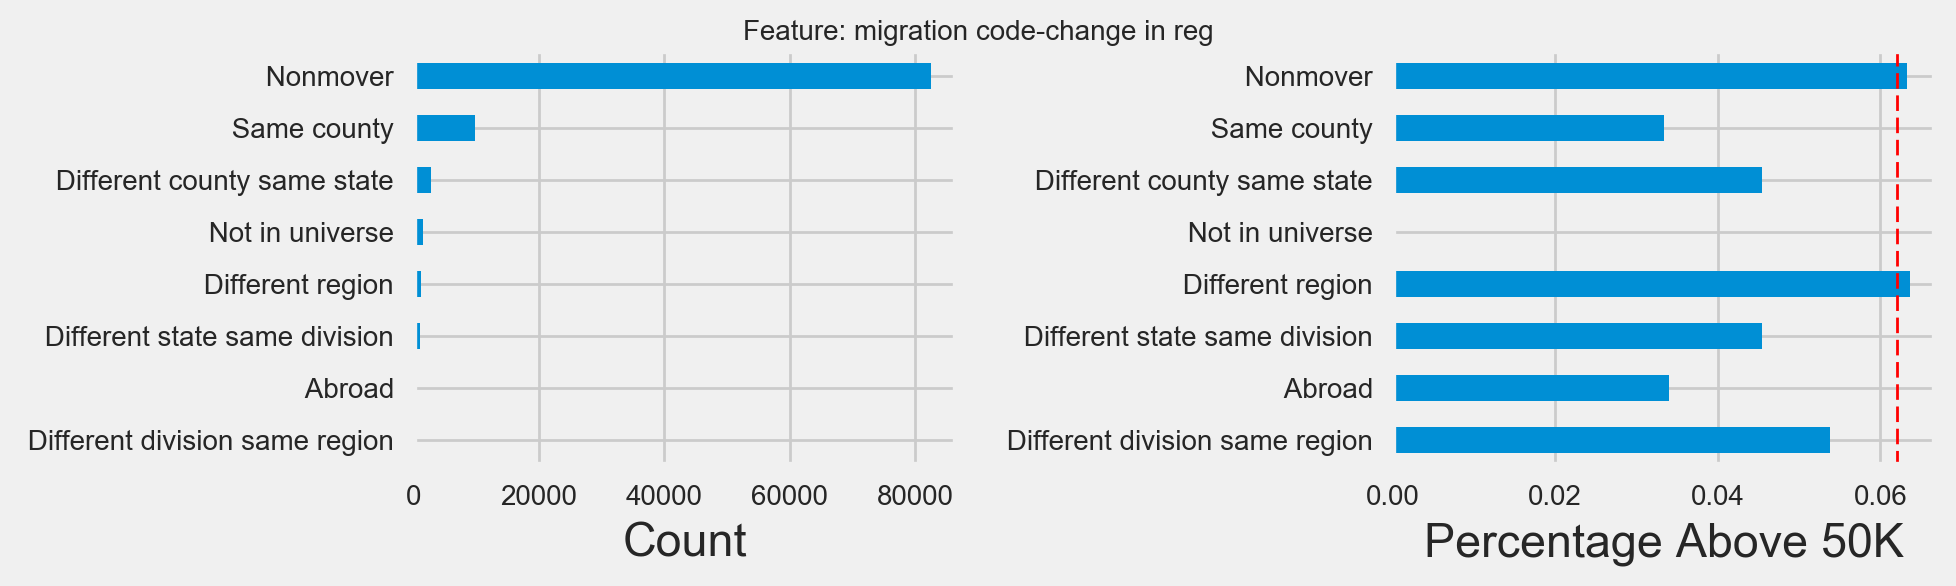

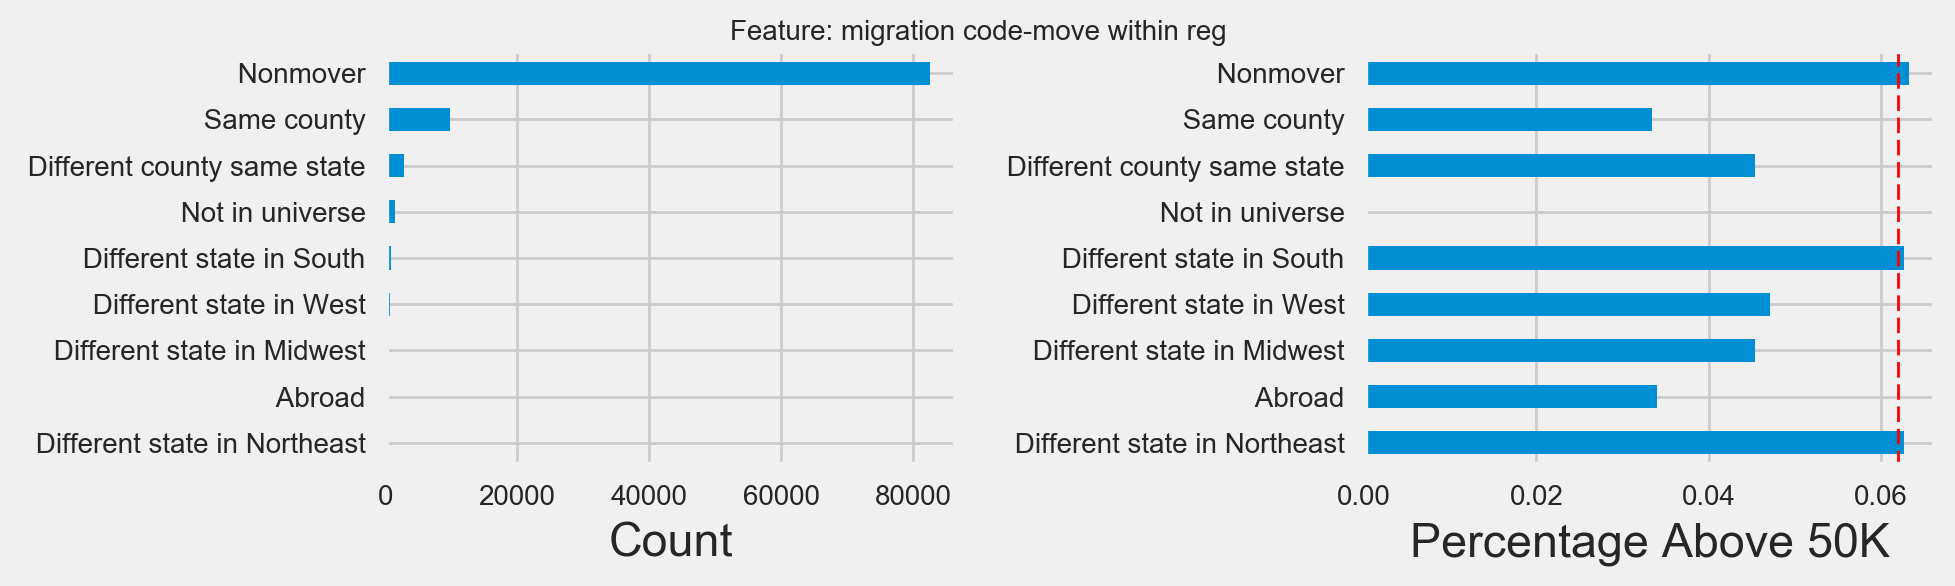

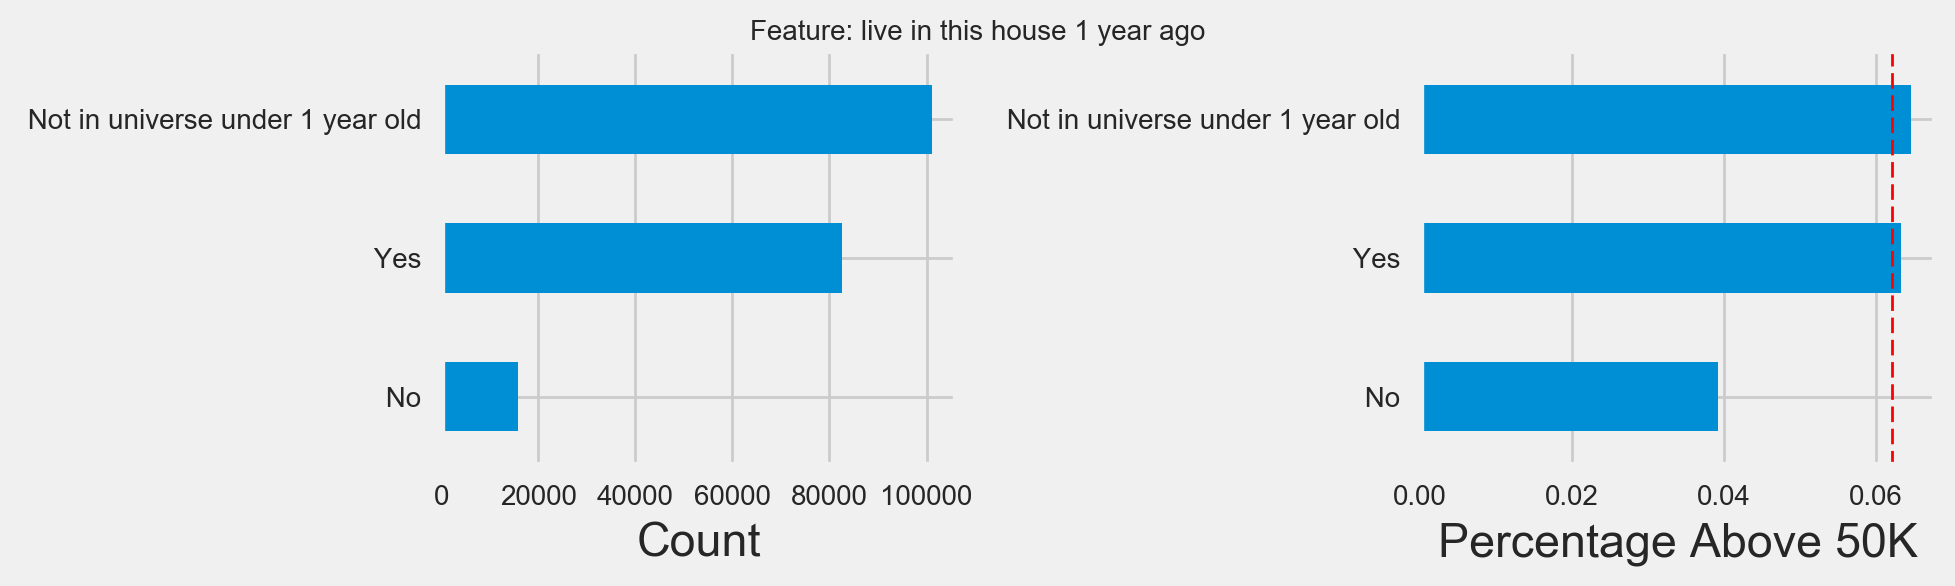

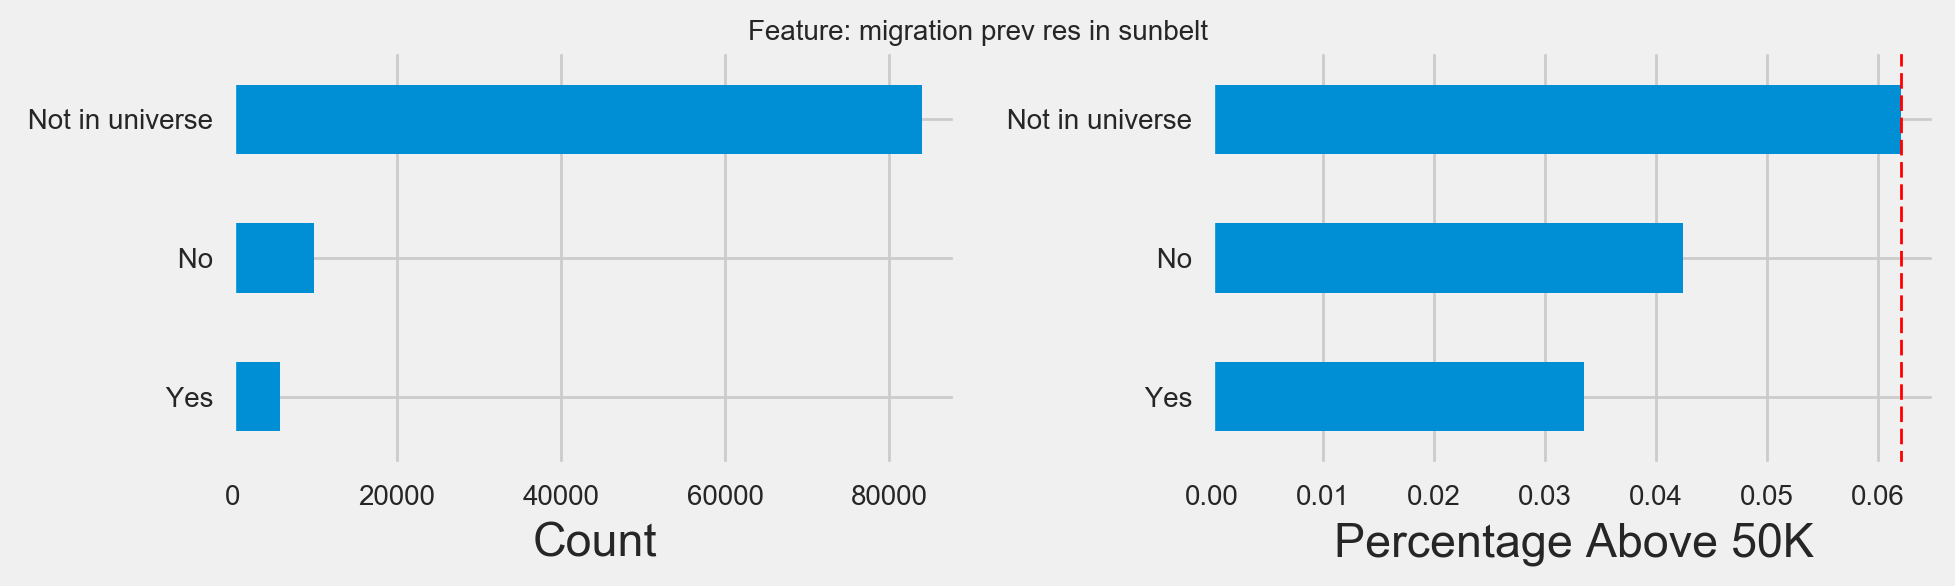

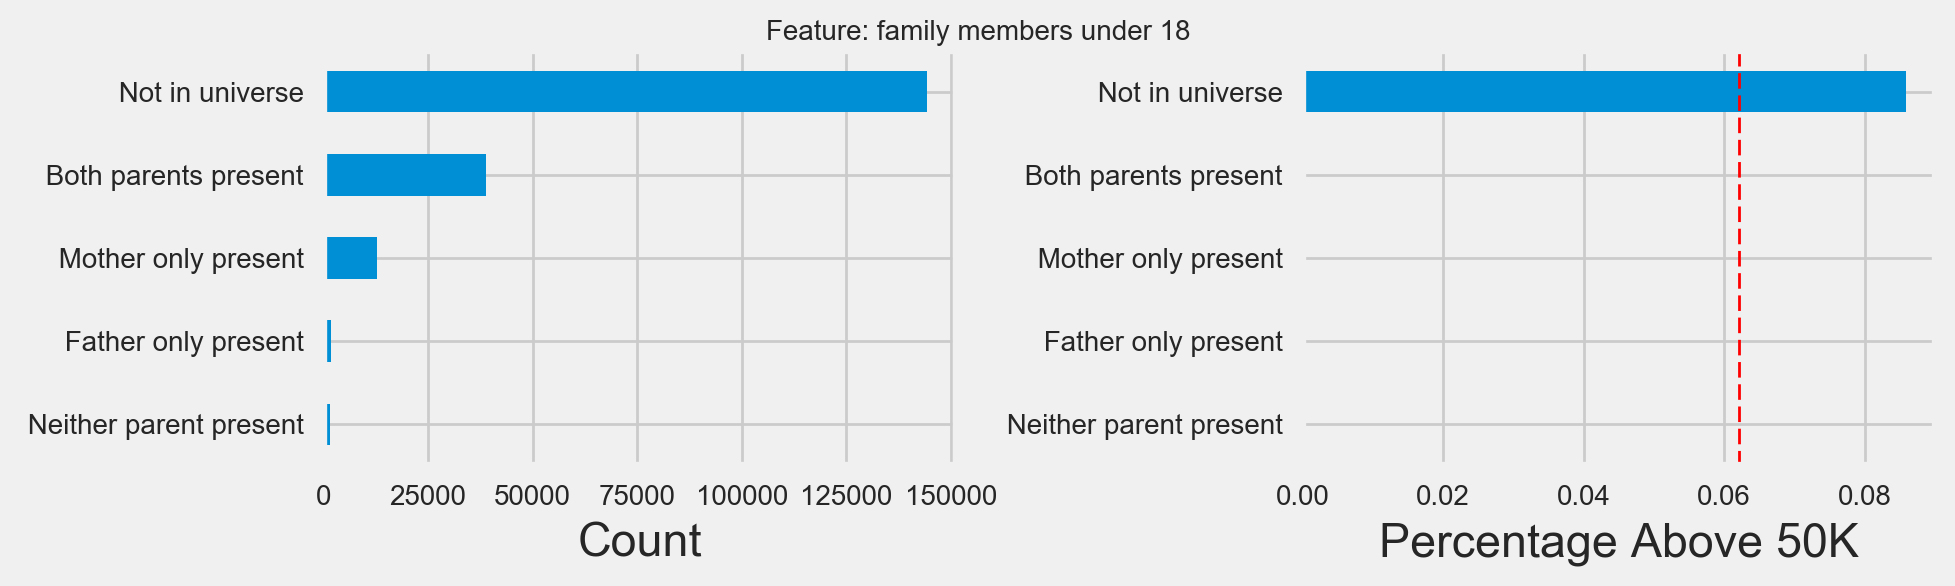

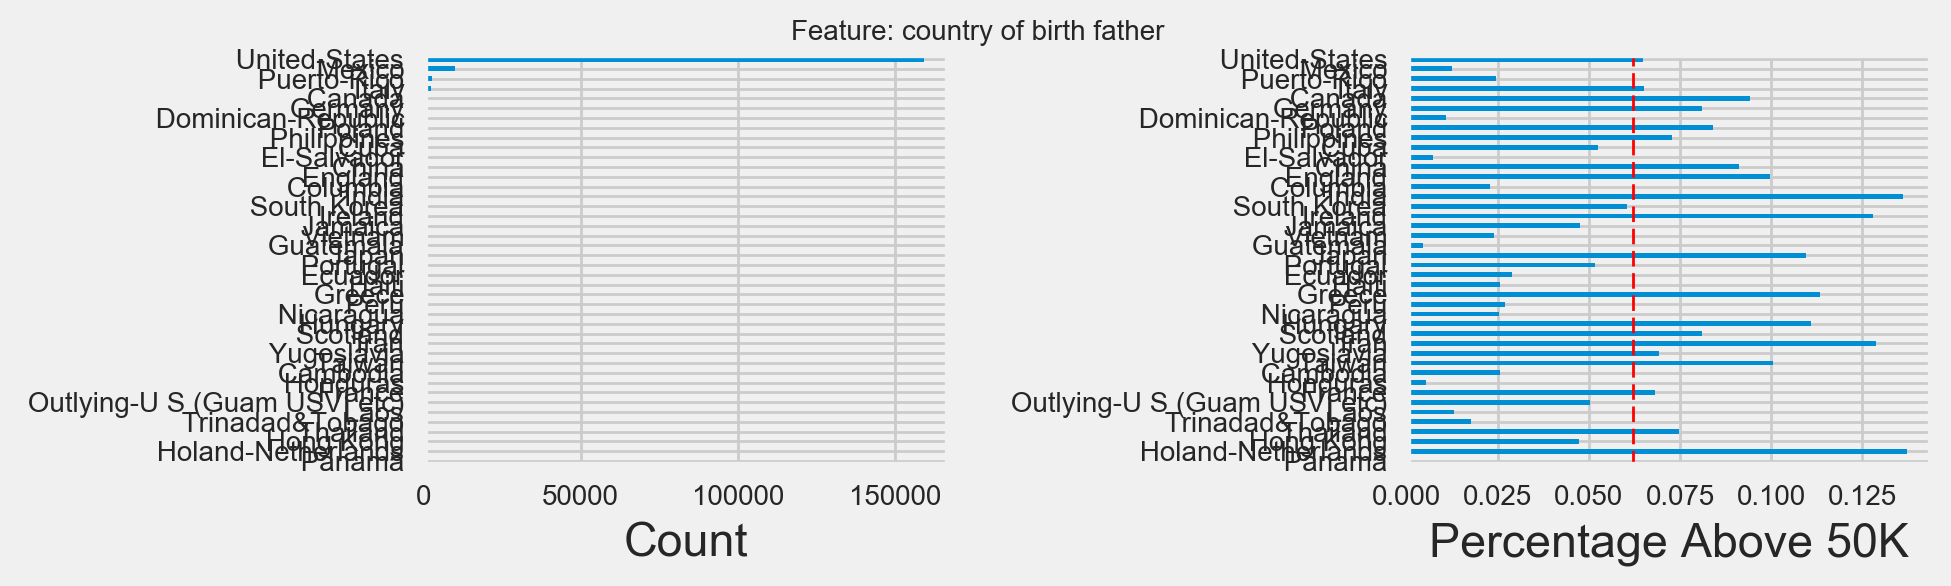

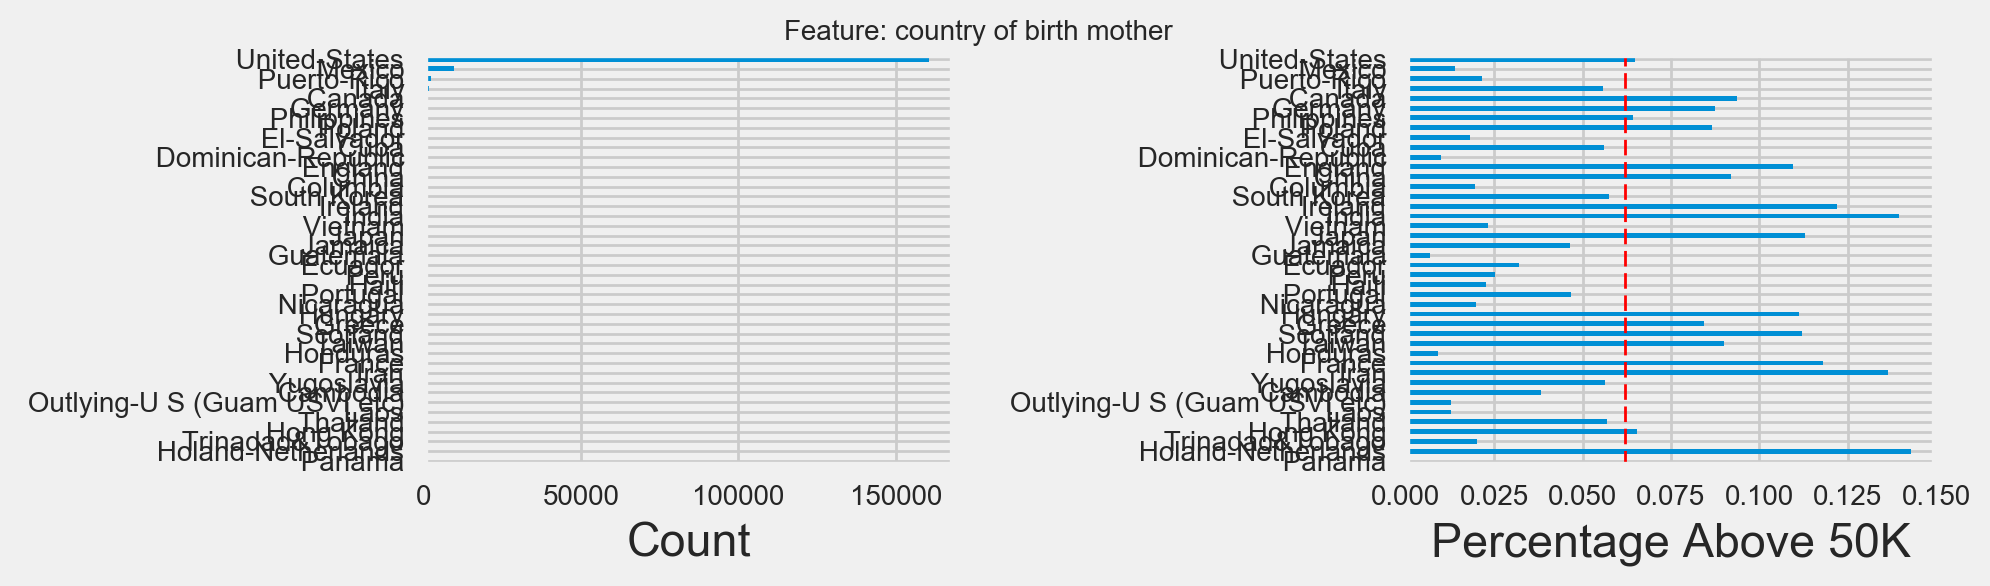

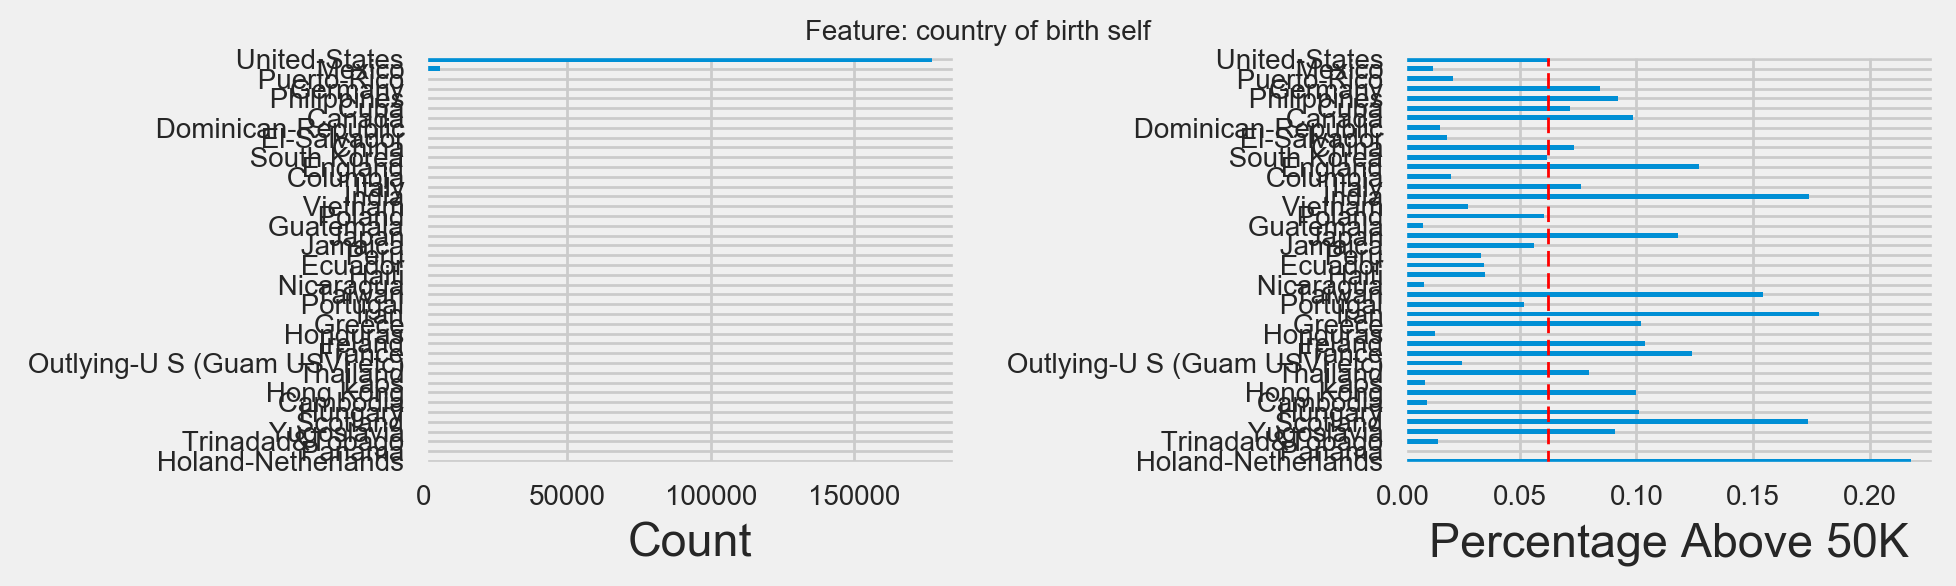

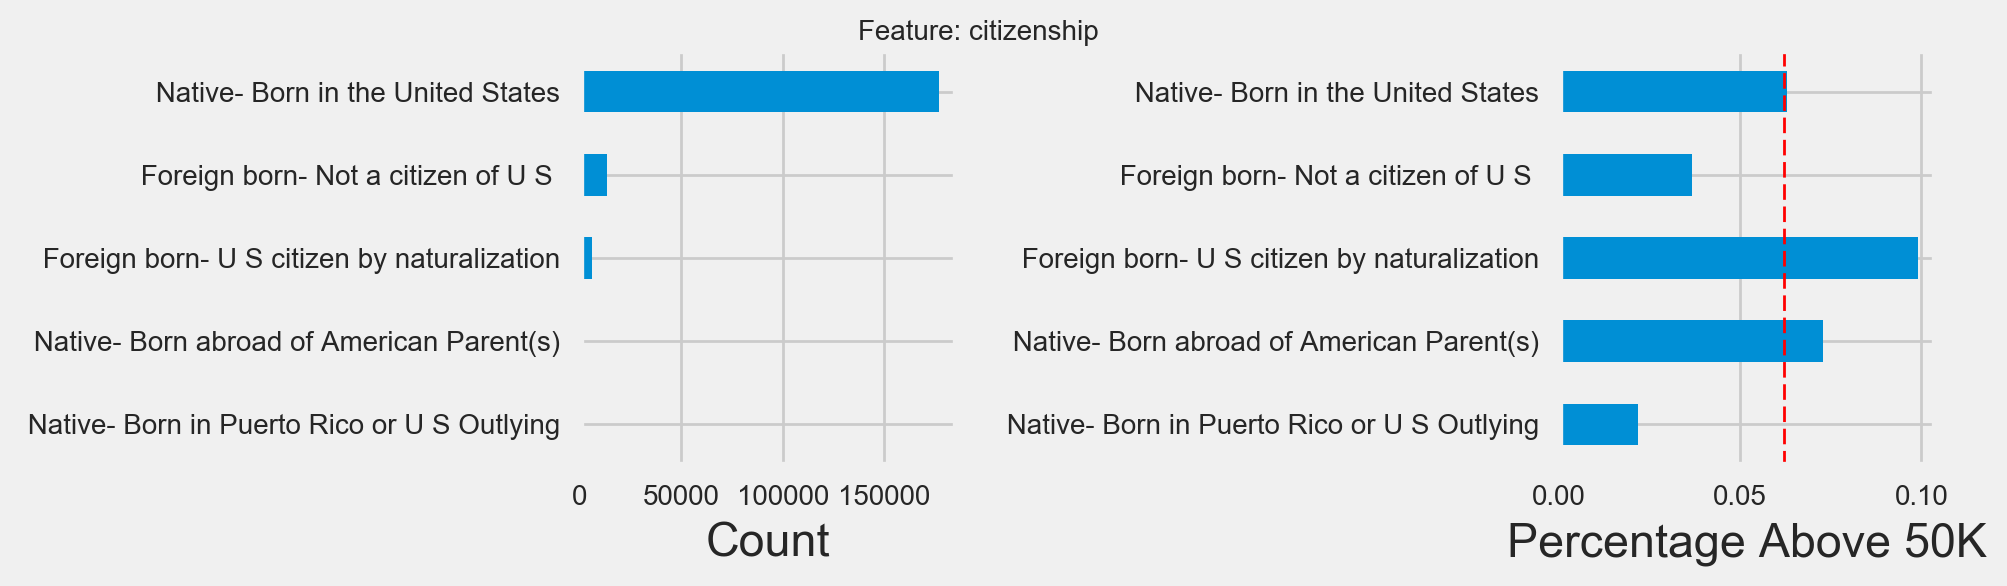

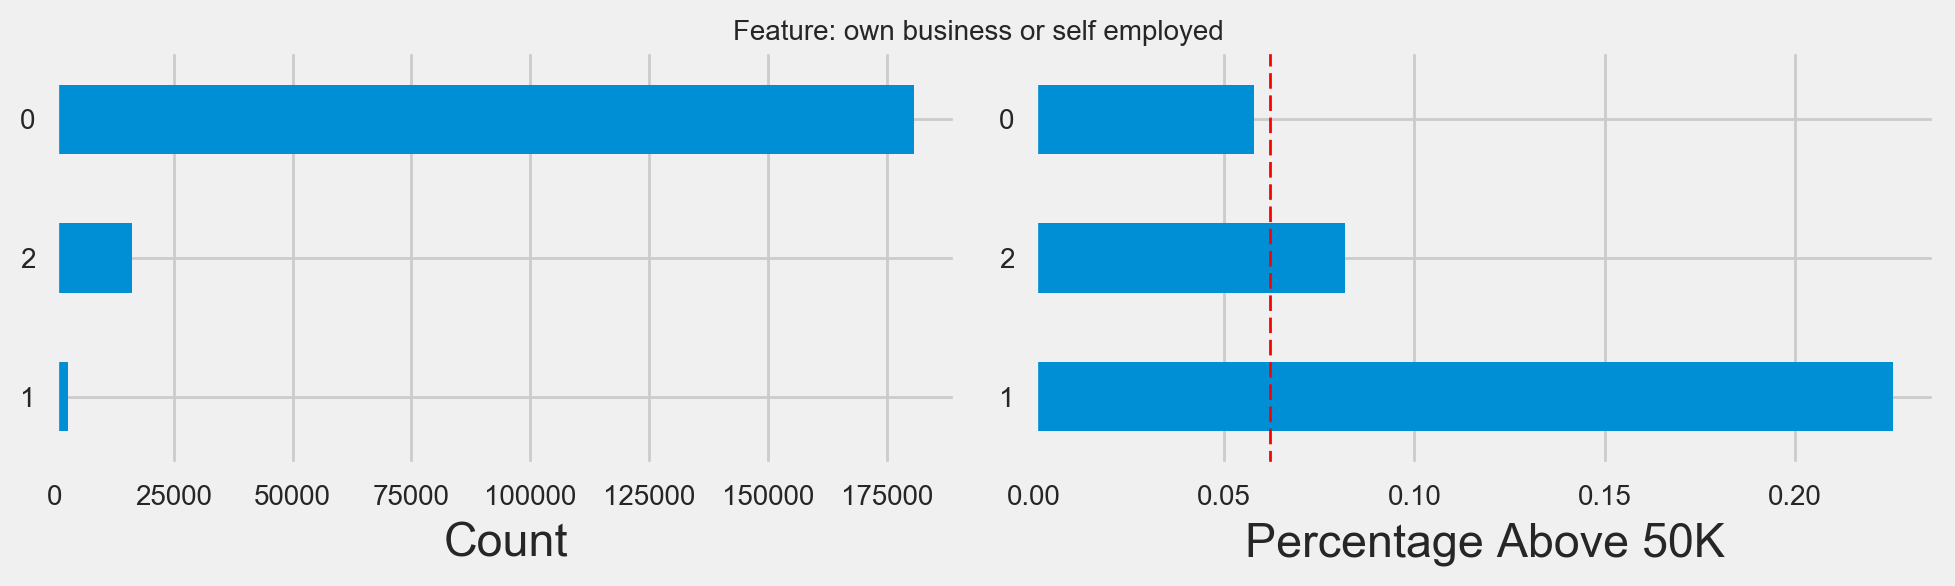

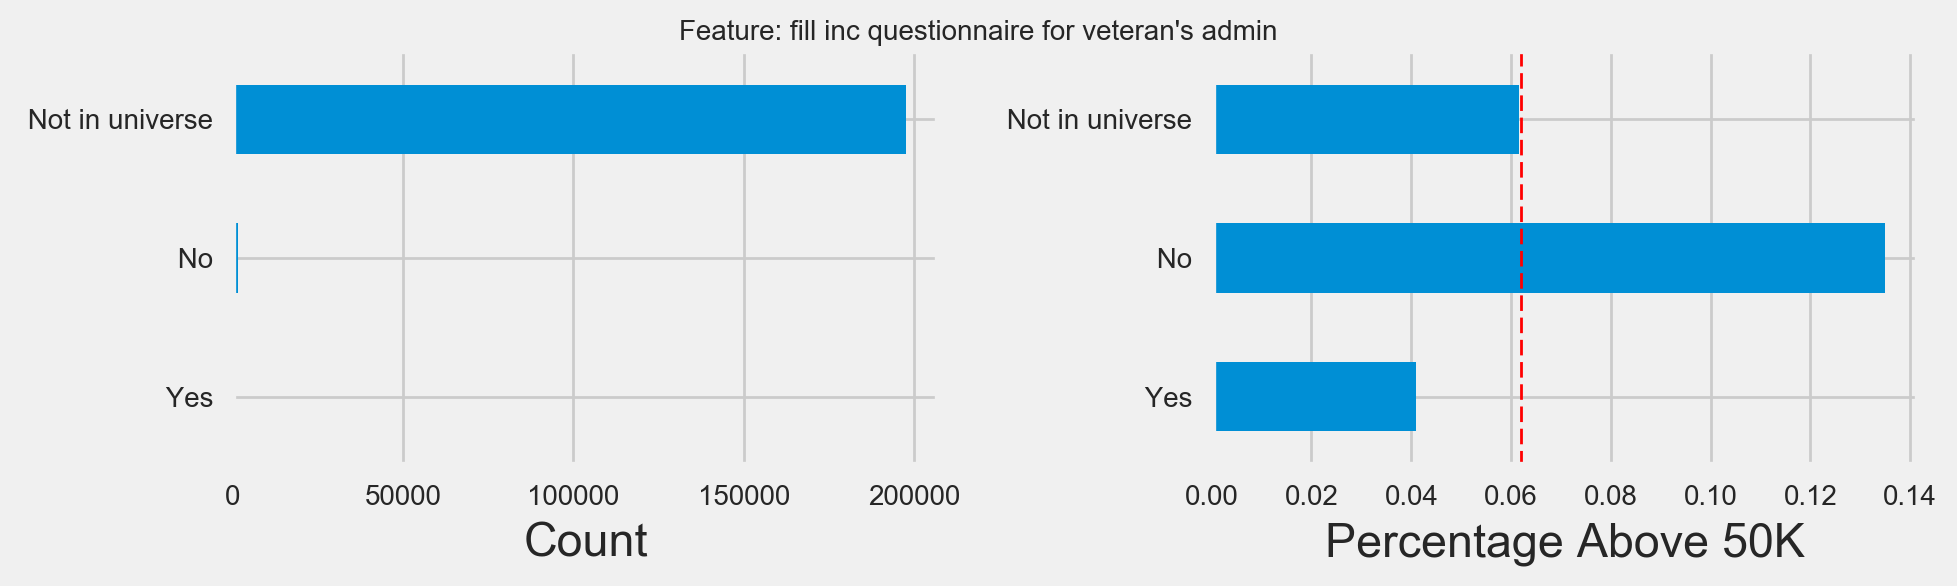

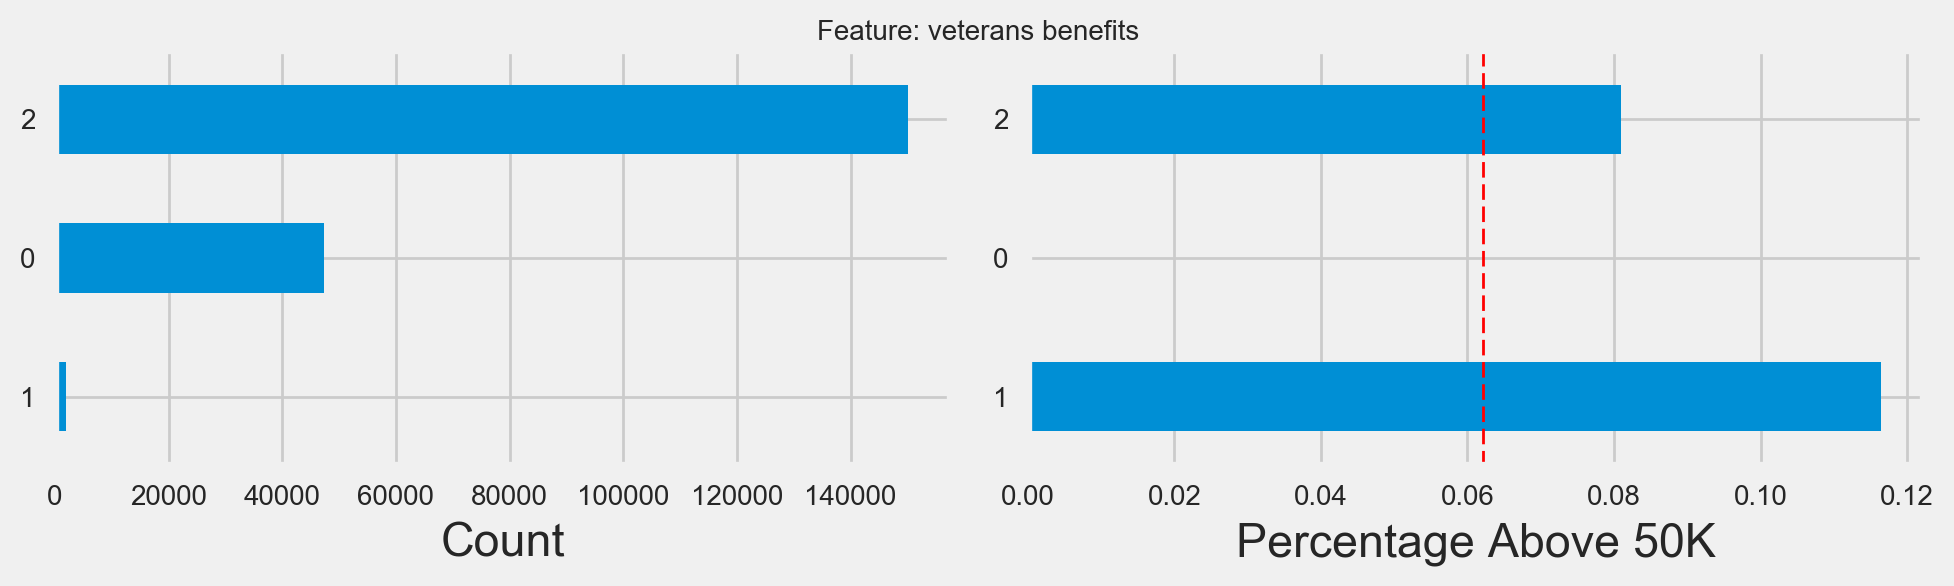

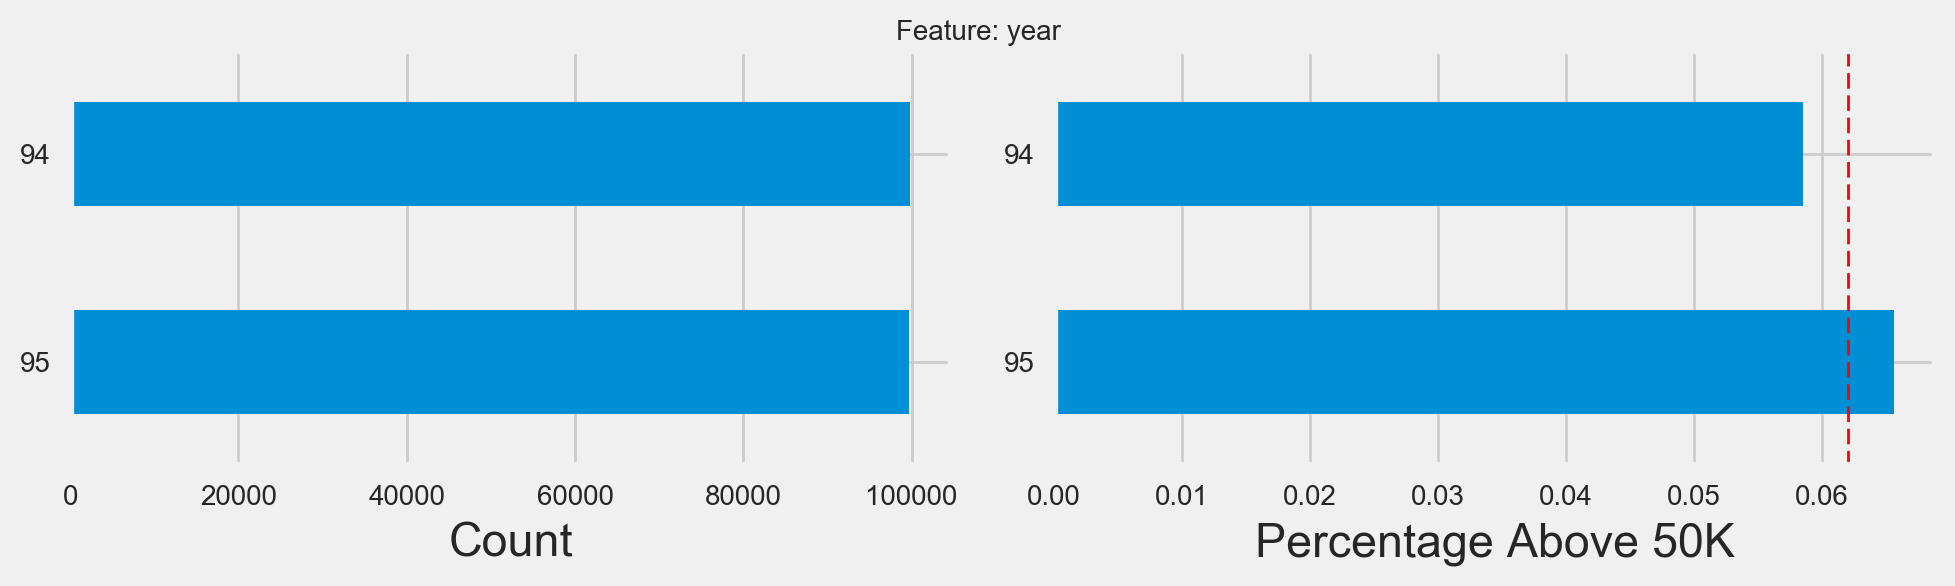

In [12]:
for col in categorical:
    fig, axes = plt.subplots(1, 2, figsize=(10,3))
    ax11 = plt.subplot(1, 2, 1)
    ax21 = plt.subplot(1, 2, 2)
    fig.suptitle('Feature: {}'.format(col), fontsize=10)
    visualize_categorical(ax11, ax21, data_train, col, 'above 50k')
    plt.tight_layout()

### 2.4 Visualization of Continuous Data

Three visualizations are made here:
- histogram (left)
- box plot(middle)
- counts of top 10 most occuring unique values (right)

In [13]:
def visualize_numeric(ax1, ax2, ax3, df, col, target):
    #plot histogram:
    df.hist(column=col, ax=ax1, bins=30)
    ax1.set_xlabel('Histogram')
    
    #plot box-whiskers:
    df.boxplot(column=col, by=target, ax=ax2)
    ax2.set_xlabel('Above 50k')
    
    #plot top 10 counts:
    cnt = df[col].value_counts().sort_values(ascending=False)
    cnt.head(10).plot(kind='barh', ax=ax3)
    ax3.invert_yaxis()  # labels read top-to-bottom
    ax3.set_xlabel('Count')

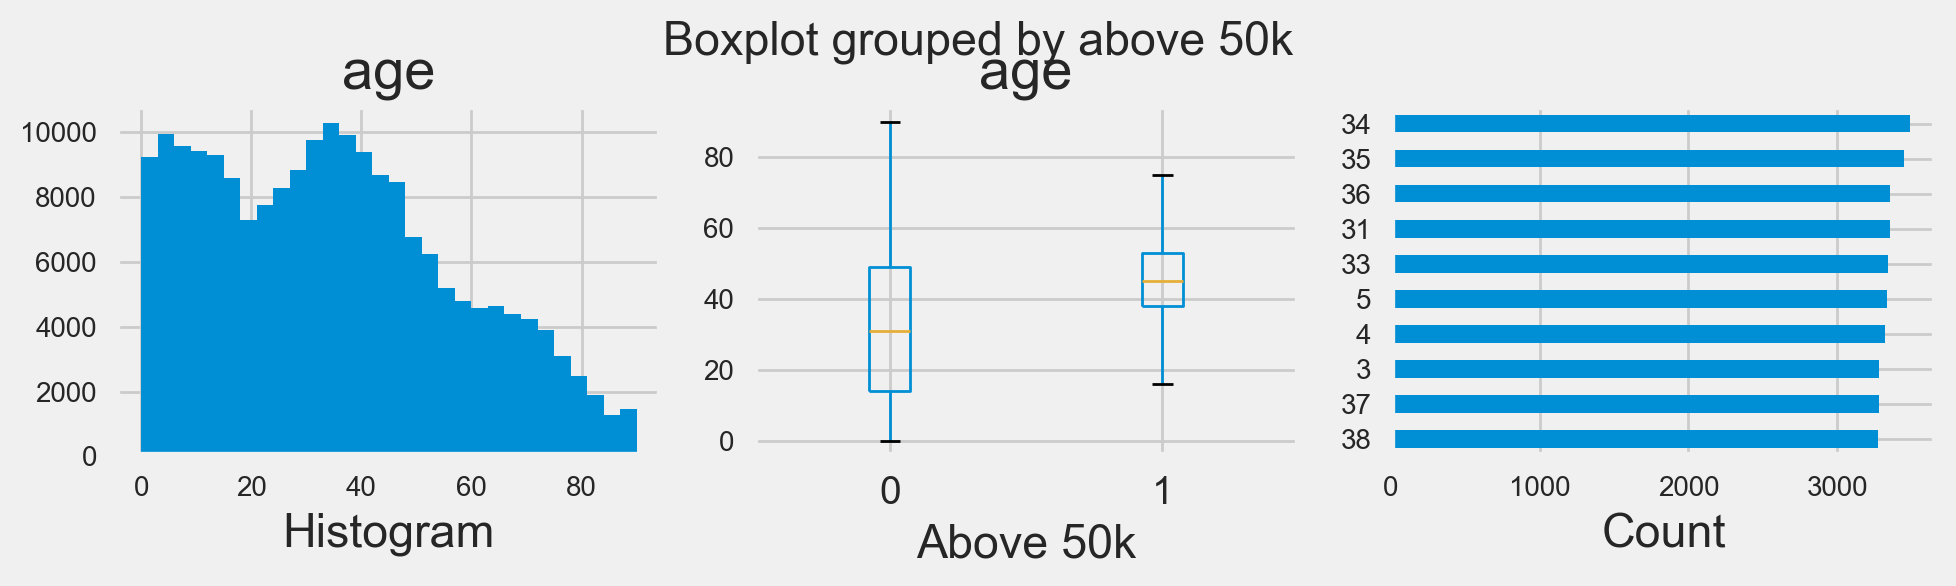

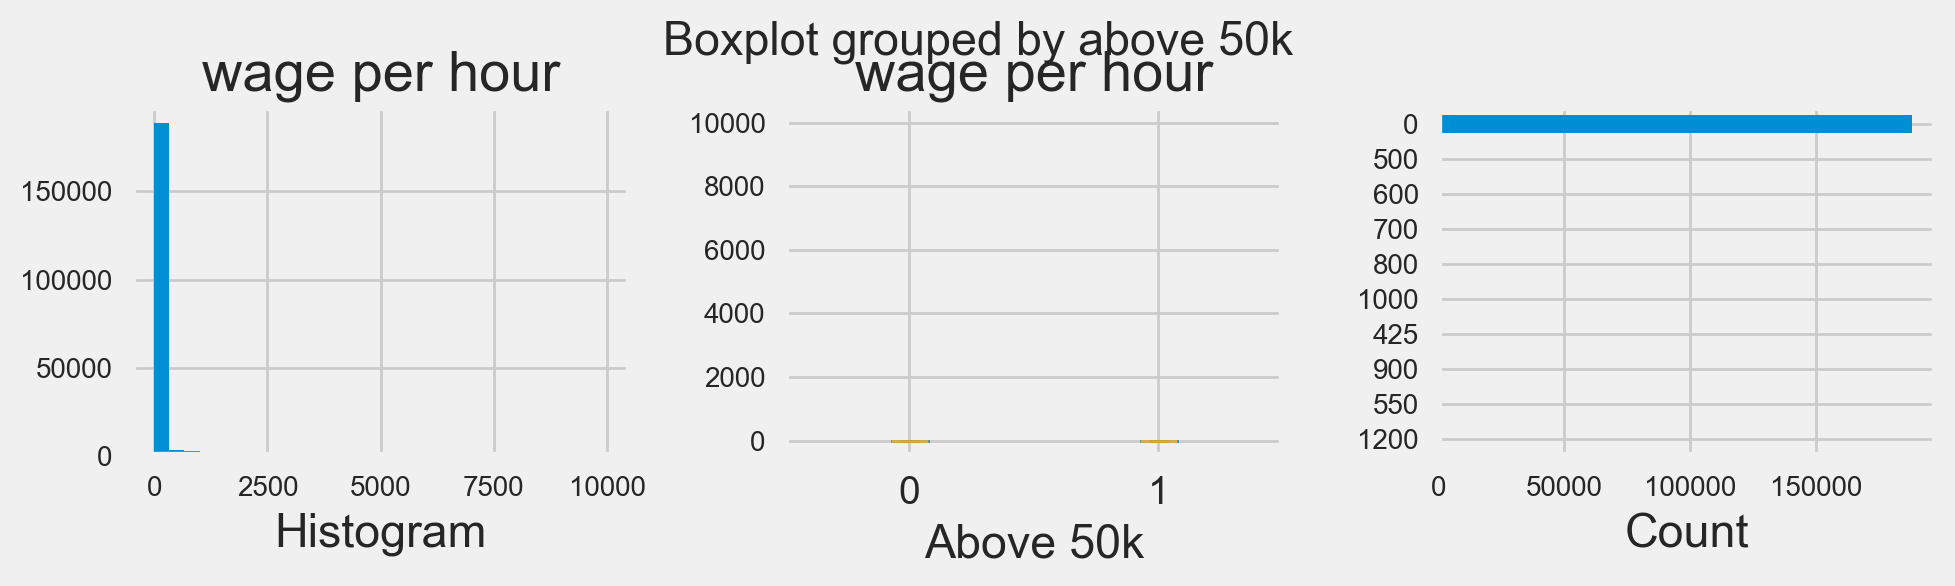

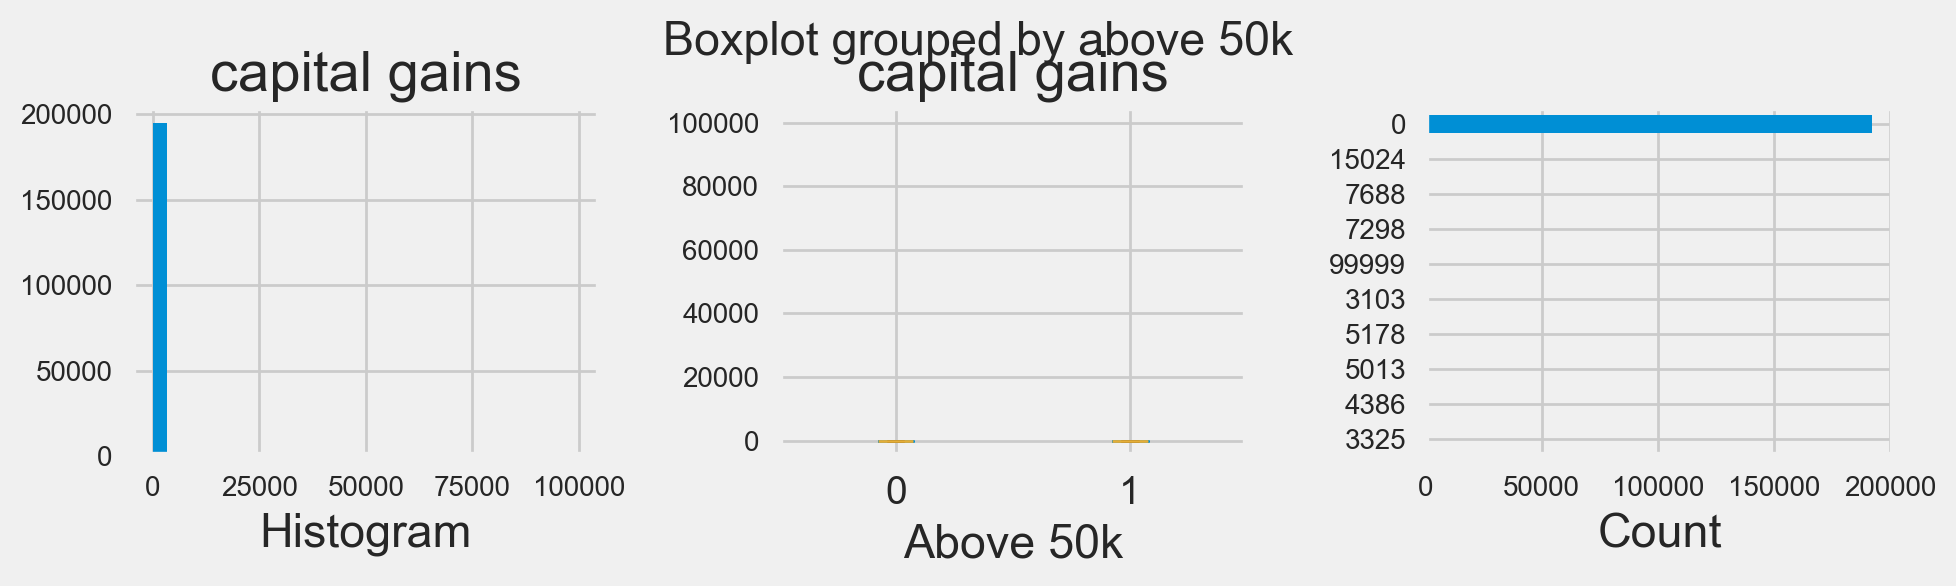

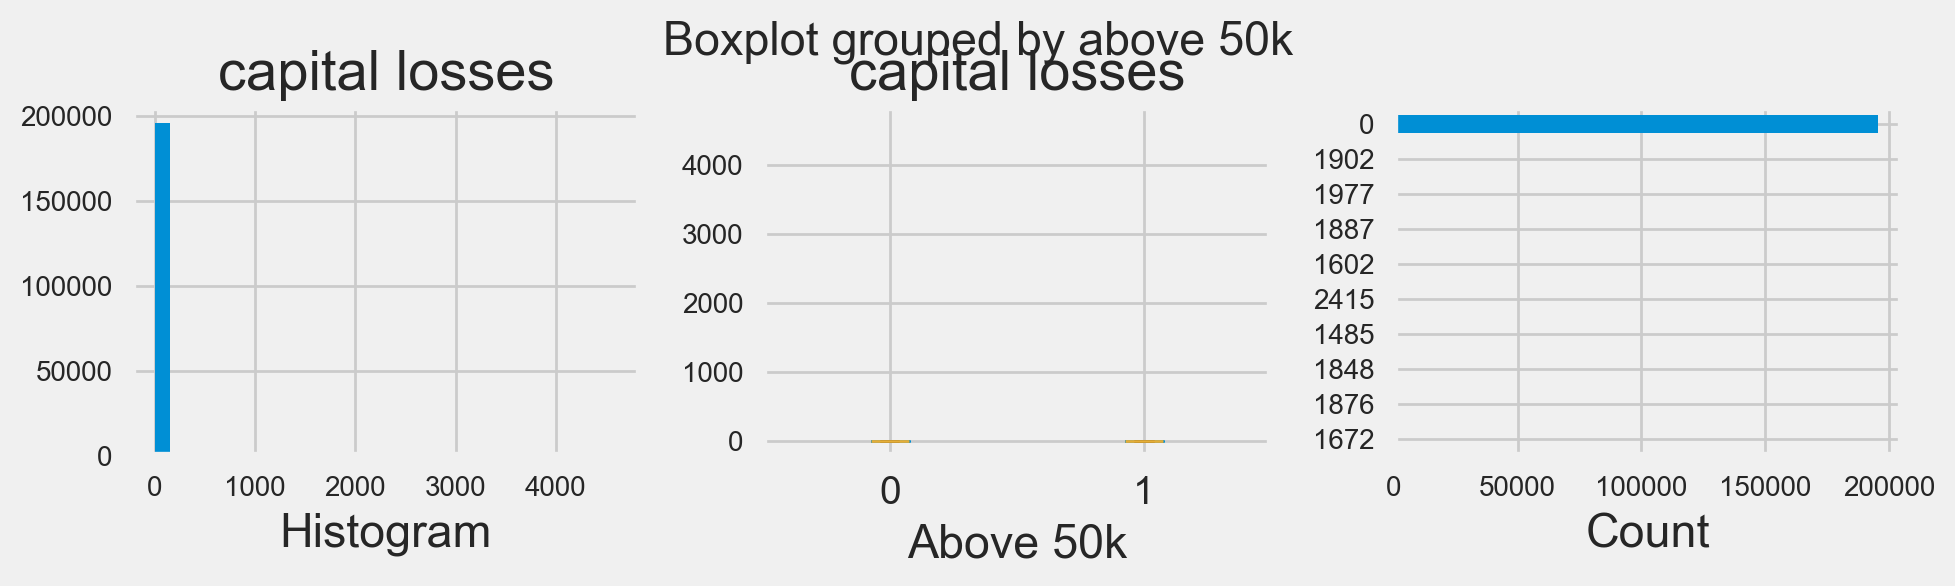

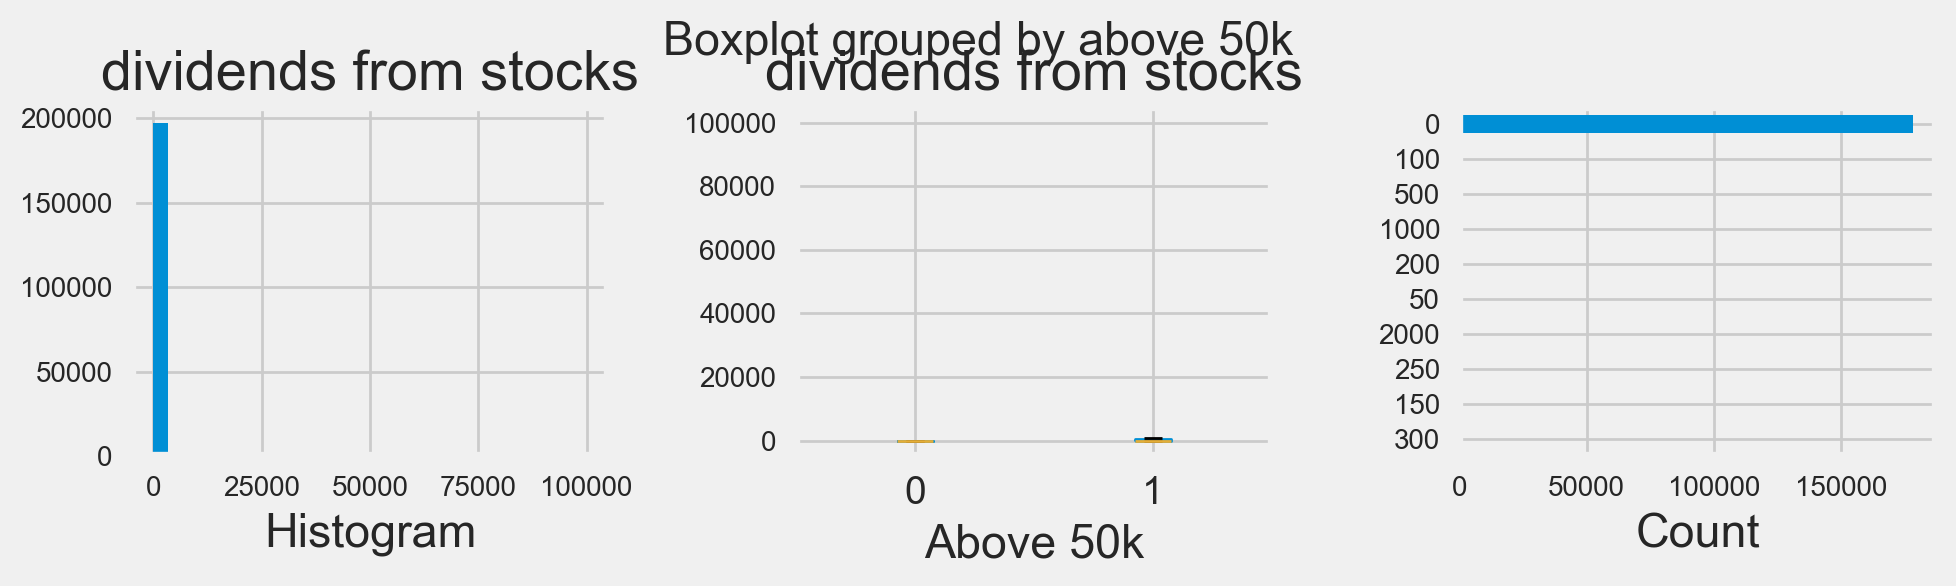

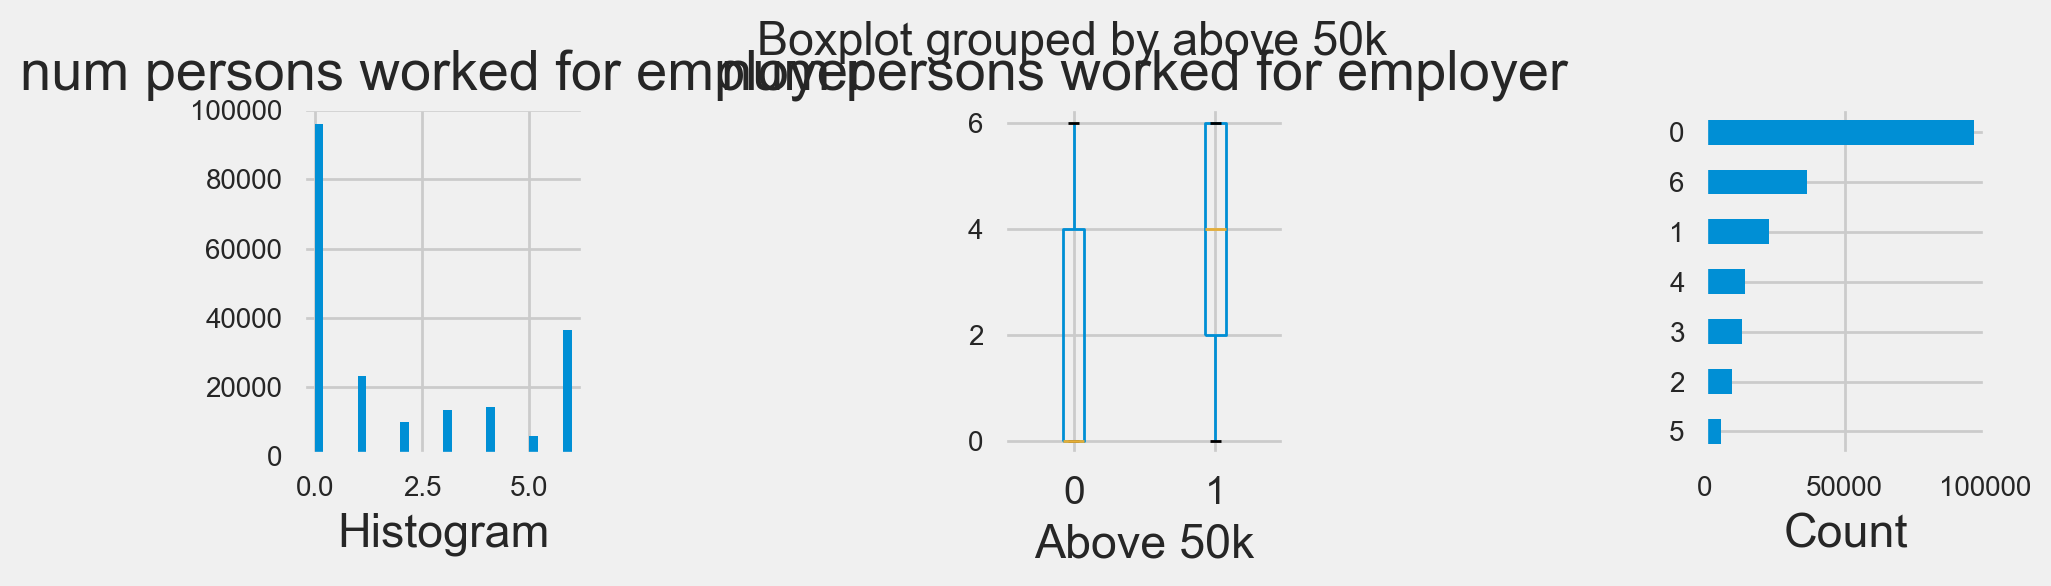

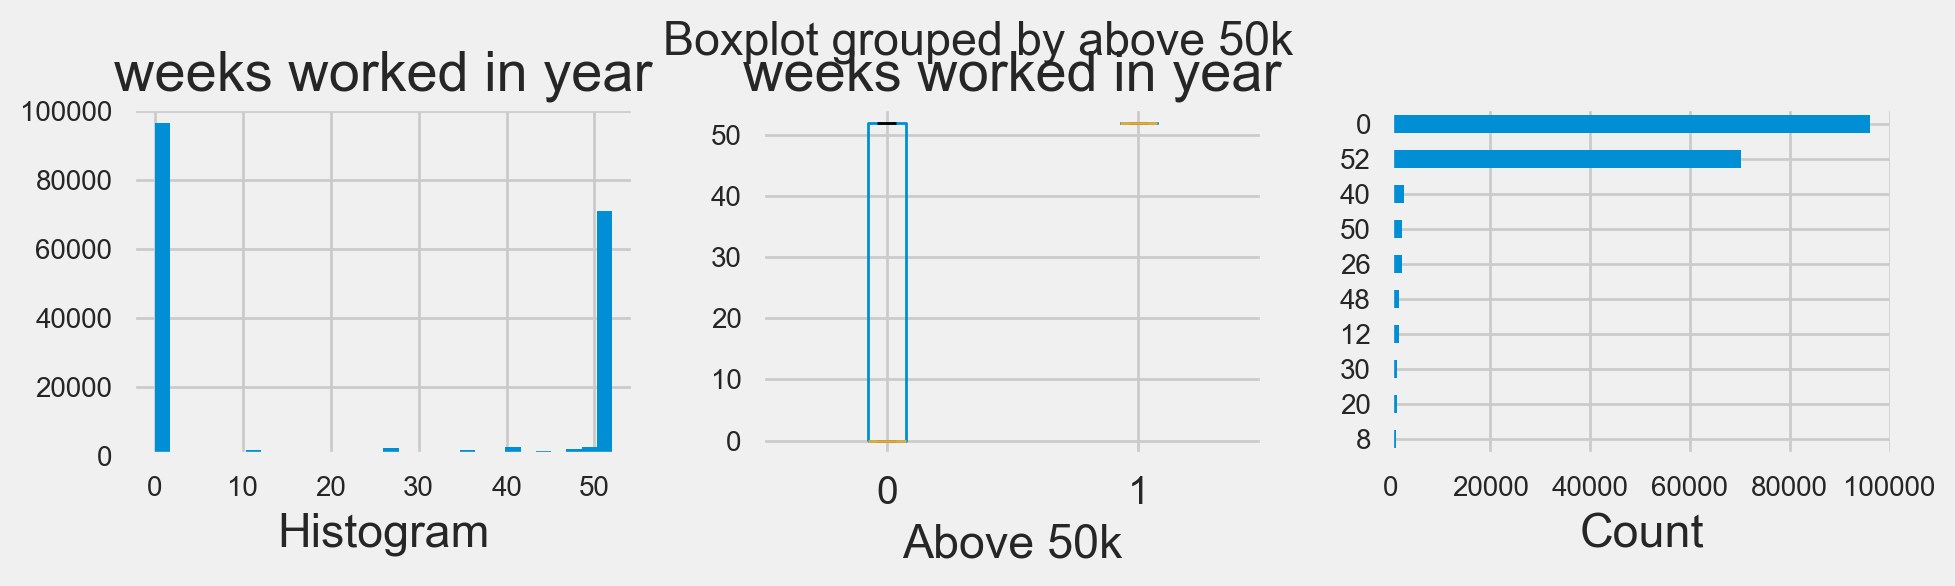

In [14]:
for col in continuous_list:
    fig, axes = plt.subplots(1, 3, figsize=(10,3))
    ax11 = plt.subplot(1, 3, 1)
    ax21 = plt.subplot(1, 3, 2)
    ax31 = plt.subplot(1, 3, 3)
    fig.suptitle('Feature: {}'.format(col), fontsize=10)
    visualize_numeric(ax11, ax21, ax31, data_train, col, 'above 50k')
    plt.tight_layout()

### 2.5 Feature Processing

Besed on the observation from value summary and visualization, 

- The four migration categories ('migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg' and 'migration prev res in sunbelt') have almost half missing values, so I coded them as separate category instead of imputing
- For imputation, we can use some techniques like fancyimpute, but i'll just use the most_frequent value here for simplicity.

- 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks' features only have few rows of meaniful values, so I'll dicard them.

- 'weeks worked in year' seems make more sense to convert to categorical type with two values: 'zero' and 'more than zero' .

In [15]:
imp_dict = {'migration code-change in msa': 'NA', 
            'migration code-change in reg': 'NA', 
            'migration code-move within reg': 'NA', 
            'migration prev res in sunbelt': 'NA',
            'state of previous residence': 'Not in universe', 
            'country of birth father': 'United-States', 
            'country of birth mother': 'United-States', 
            'country of birth self': 'United-States'}

data_train = data_train.fillna(imp_dict)
data_test = data_test.fillna(imp_dict)

In [16]:
rm_list = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

# drop 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks'
data_train.drop(rm_list, axis=1, inplace=True)
data_test.drop(rm_list, axis=1, inplace=True)

In [17]:
data_train['weeks worked in year'] = data_train['weeks worked in year'].apply(lambda x: 'zero' if x==0 else 'more than zero')
data_test['weeks worked in year'] = data_test['weeks worked in year'].apply(lambda x: 'zero' if x==0 else 'more than zero')

In [18]:
categorical_list = categorical_list+['weeks worked in year']
continuous_list = [x for x in continuous_list if x not in rm_list+['weeks worked in year']]

In [19]:
for col in categorical_list:
    data_train[col] = data_train[col].astype('category')
    data_test[col] = data_test[col].astype('category', categories=data_train[col].cat.categories)

In [20]:
# create dummies
data_train_encode = pd.get_dummies(data_train, columns=categorical_list)
data_test_encode = pd.get_dummies(data_test, columns=categorical_list)

In [21]:
X_train = data_train_encode.drop('above 50k', axis=1)
y_train = data_train_encode['above 50k']

X_test = data_test_encode.drop('above 50k', axis=1)
y_test = data_test_encode['above 50k']

## Build Model <a class="anchor" id="build-model"></a>

- Models are measured by roc_auc score, since data is very imbalanced
- Acccording to goal of this task is not achieving highest scores, models are simply tuned by one param each.
- A soft voting classfier with best param setting are built in the end and used as final model.

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV

### 3.1 Logistic Regression

In [24]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid={'C': np.logspace(-4, 2, 5)}, 
                       cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([   0.0001 ,    0.00316,    0.1    ,    3.16228,  100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [25]:
print("best param: {}".format(grid_lr.best_params_))
print("best train score: {}".format(grid_lr.best_score_))
print("best test score: {}".format(grid_lr.score(X_test, y_test)))

best param: {'C': 0.10000000000000001}
best train score: 0.9330702452532045
best test score: 0.9346374222642578


(0, 50)

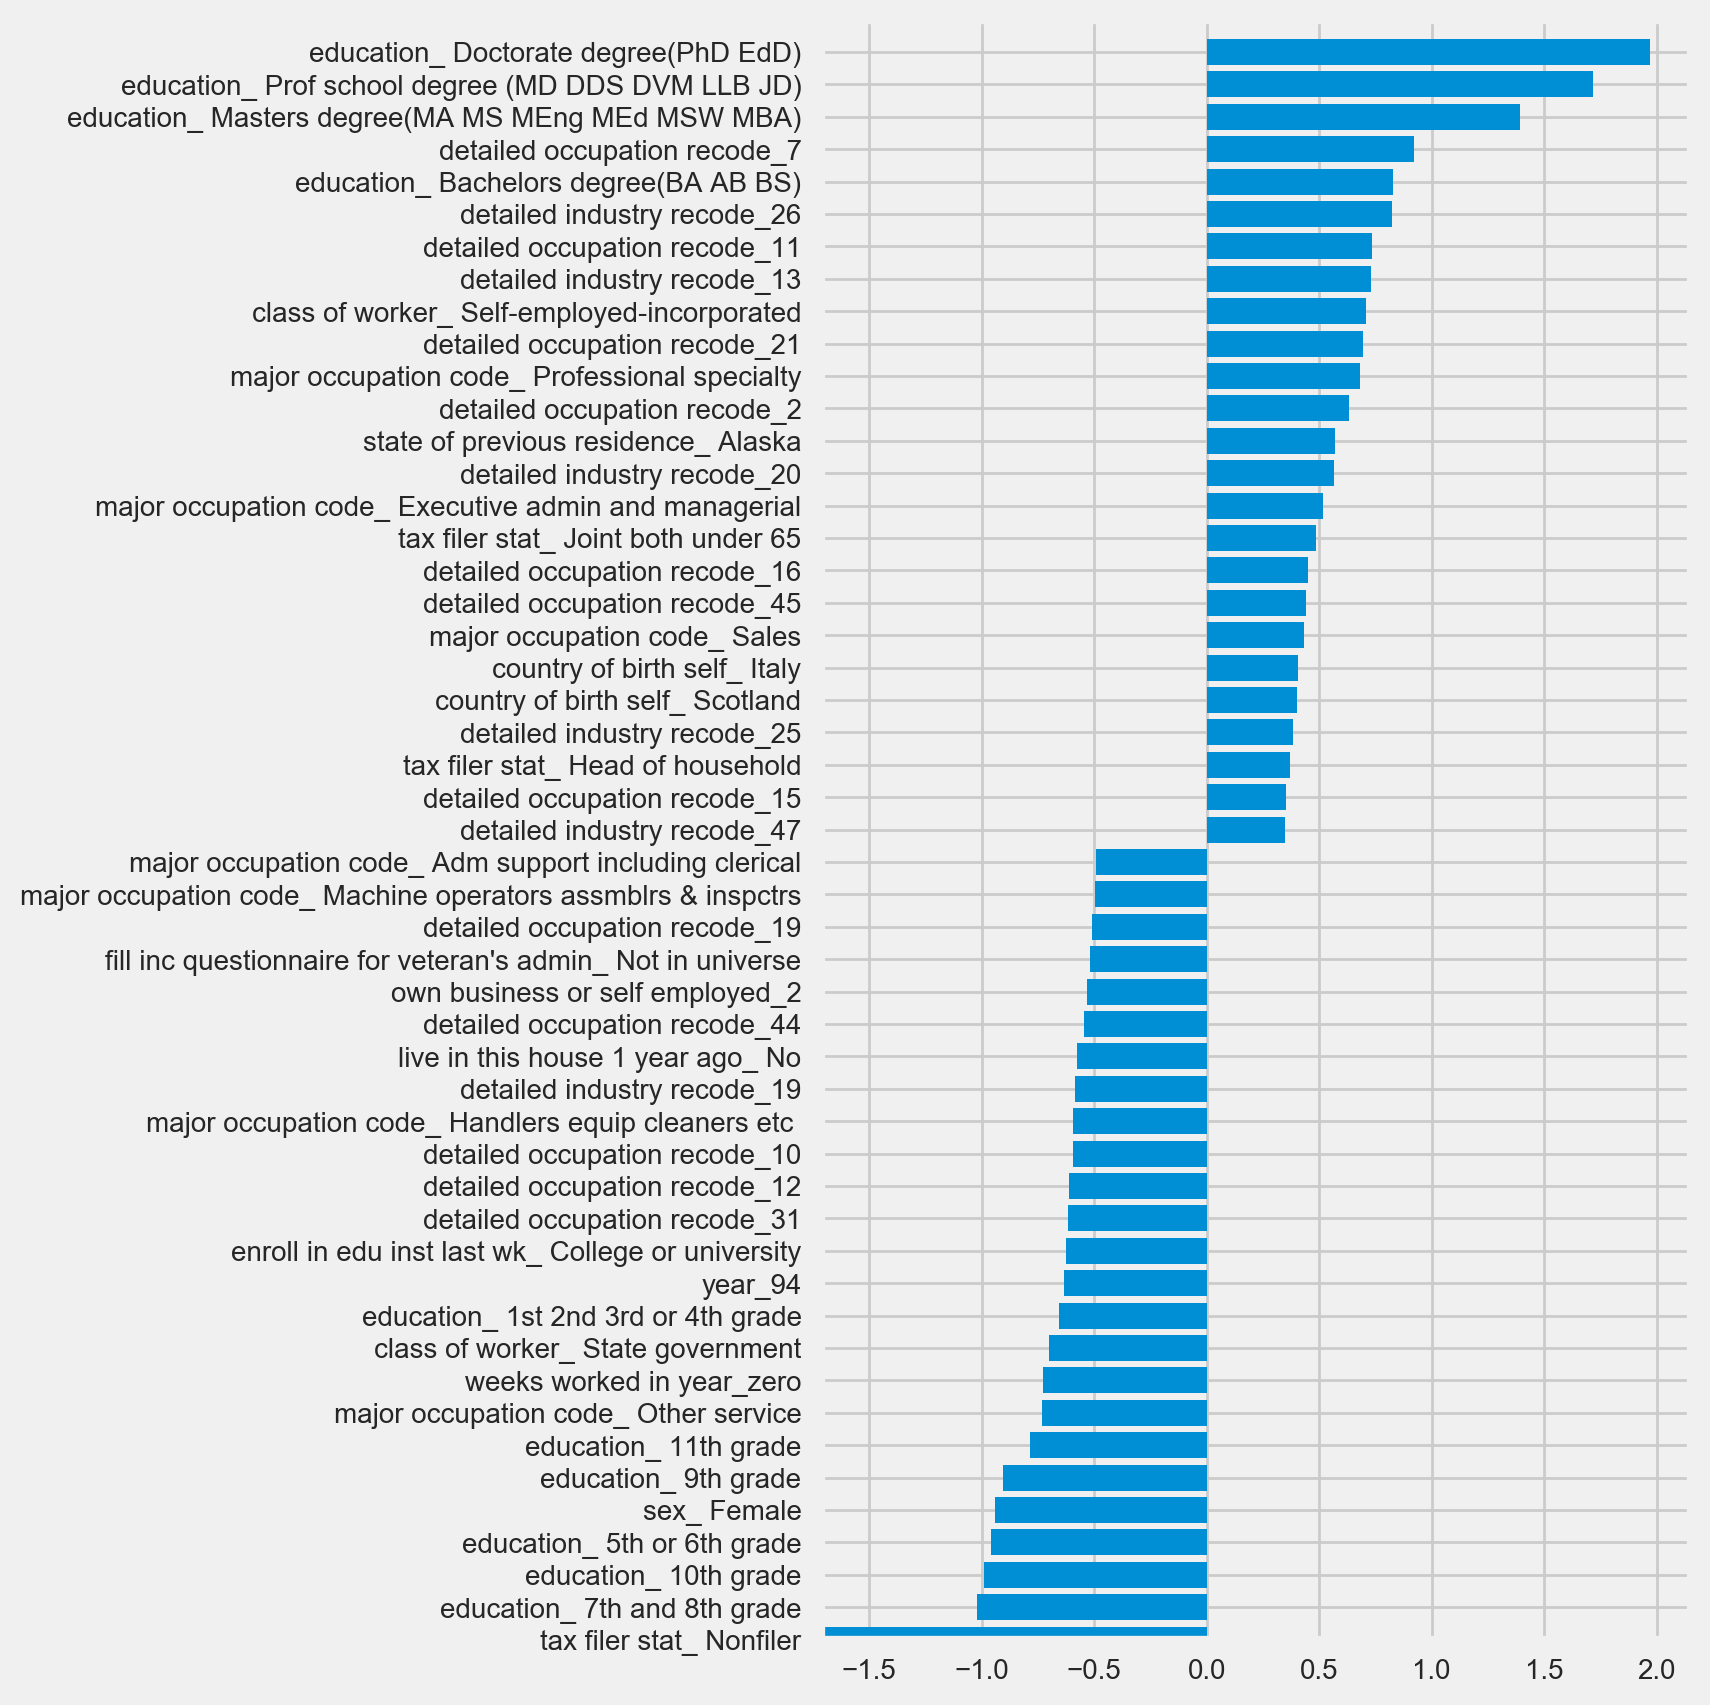

In [26]:
top_n = 50
coef = grid_lr.best_estimator_.coef_[-1, :]

inds = np.argsort(coef)
inds = np.hstack([inds[:top_n // 2], inds[-top_n//2:]])

plt.figure(figsize=(5, 10))
plt.barh(np.arange(top_n), coef[inds[-top_n:]])
plt.yticks(np.arange(top_n), X_train.columns[inds[-top_n:]])
plt.ylim(0, top_n)

### 3.2 Decision Tree

In [27]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid={'max_depth': range(1, 5)}, 
                       cv=5, scoring='roc_auc', n_jobs=-1)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [28]:
print("best param: {}".format(grid_dt.best_params_))
print("best train score: {}".format(grid_dt.best_score_))
print("best test score: {}".format(grid_dt.score(X_test, y_test)))

best param: {'max_depth': 4}
best train score: 0.8565381106304422
best test score: 0.8552835951660779


(0, 50)

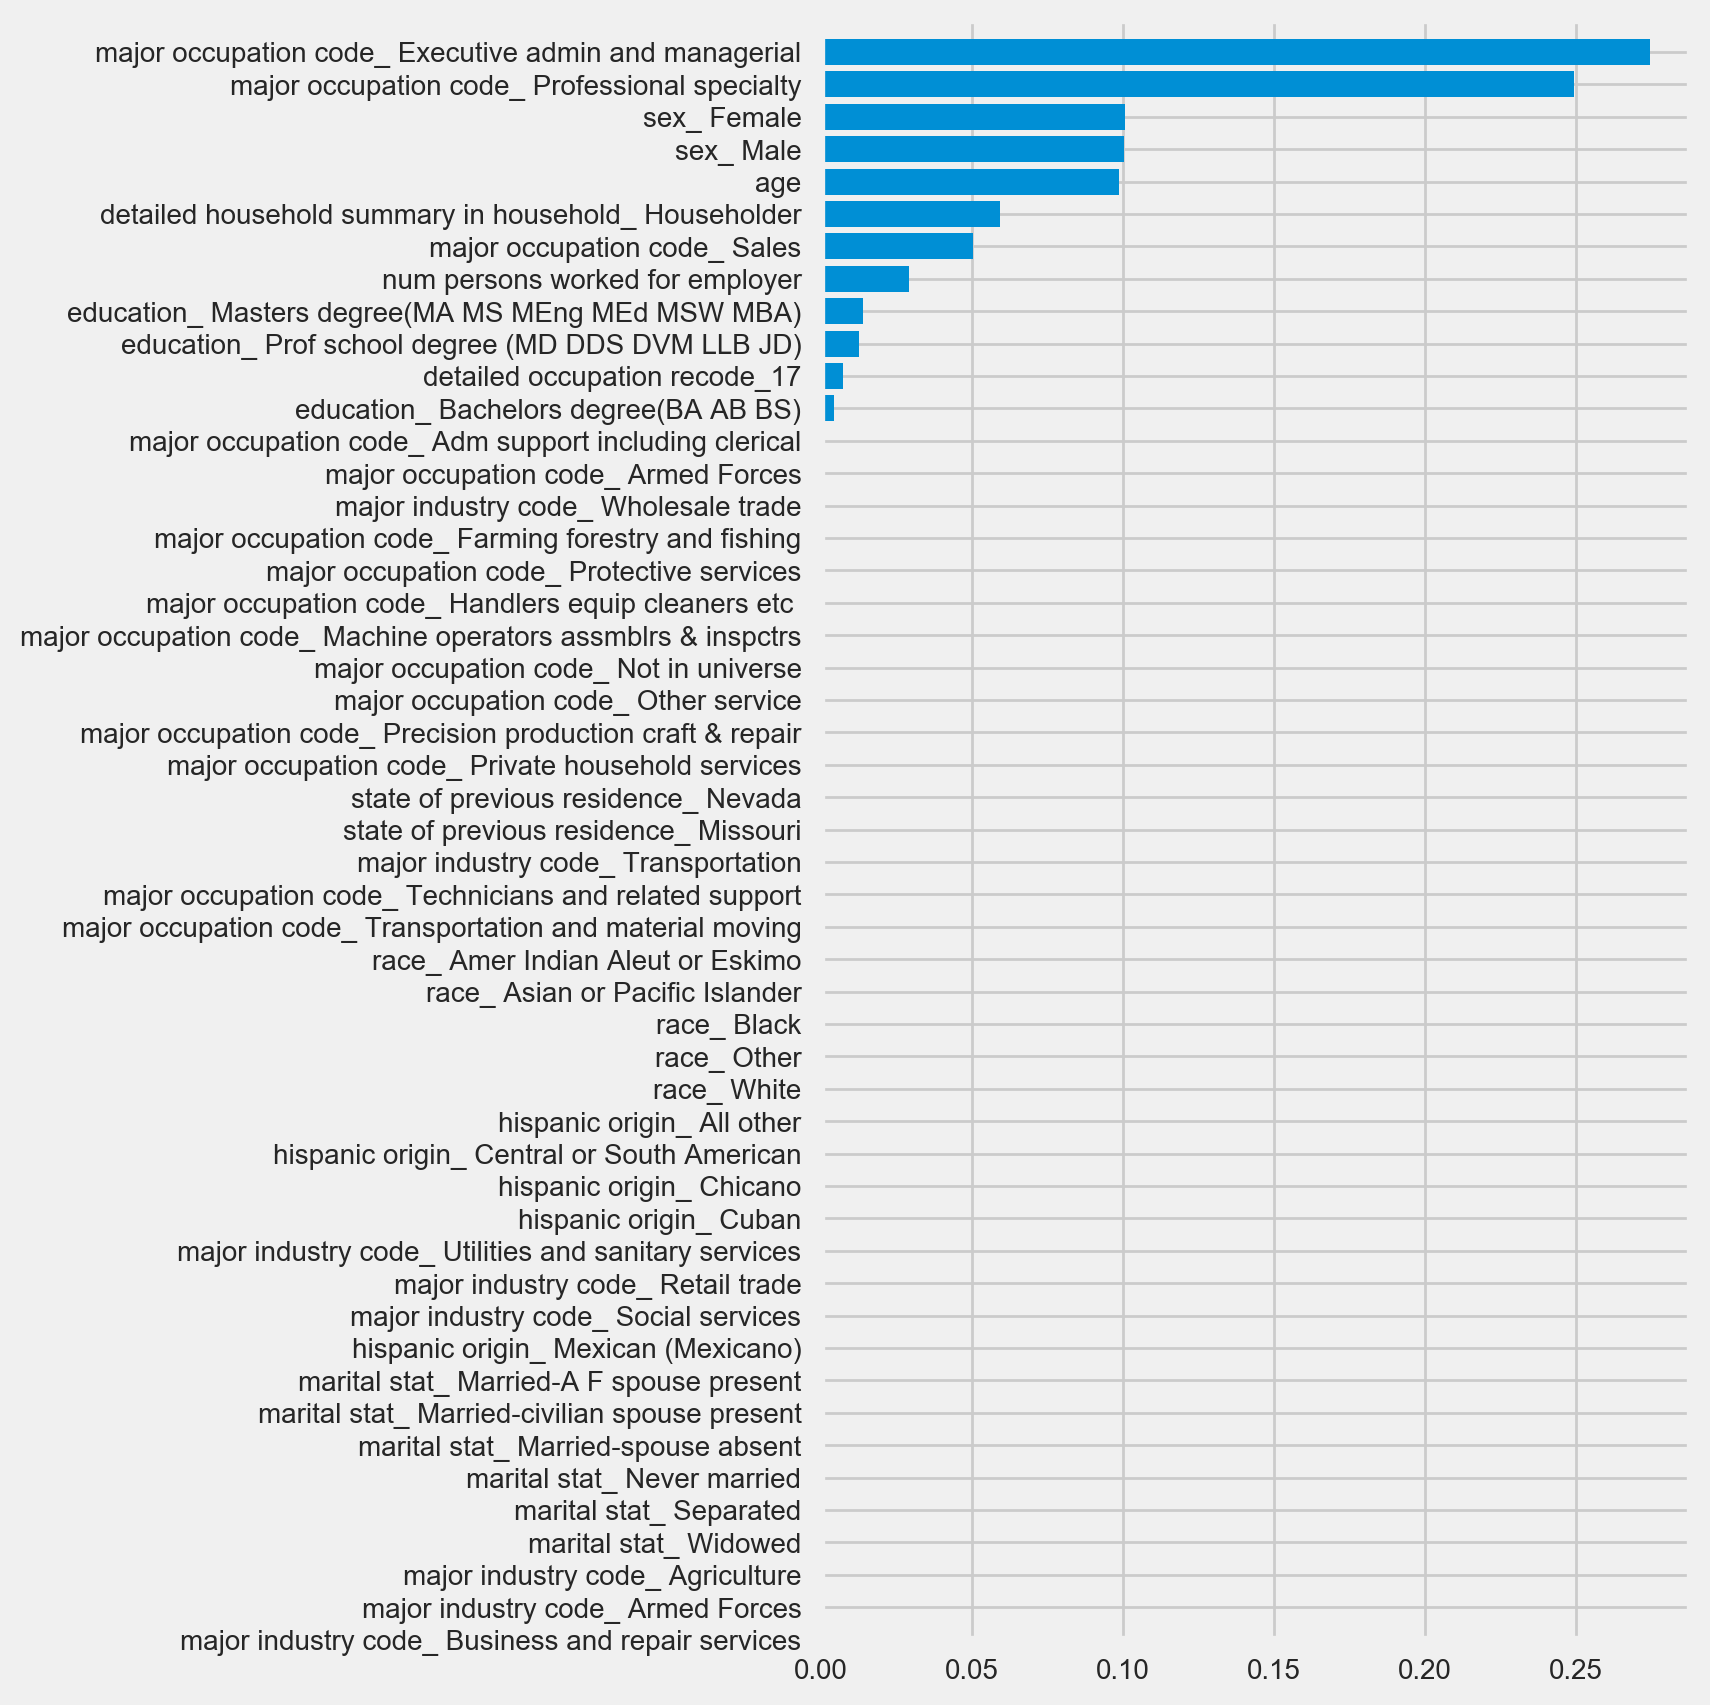

In [29]:
top_n = 50
coef = grid_dt.best_estimator_.feature_importances_
inds = np.argsort(coef)
plt.figure(figsize=(5, 10))
plt.barh(np.arange(top_n), coef[inds[-top_n:]])

plt.yticks(np.arange(top_n), X_train.columns[inds[-top_n:]])
plt.ylim(0, top_n)

### 3.3 Random Forest

In [30]:
grid_rf = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                       param_grid={'max_depth': range(3, 8)}, 
                       cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 8)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [31]:
print("best param: {}".format(grid_rf.best_params_))
print("best train score: {}".format(grid_rf.best_score_))
print("best test score: {}".format(grid_rf.score(X_test, y_test)))

best param: {'max_depth': 7}
best train score: 0.9134911668916229
best test score: 0.9148369031290434


(0, 50)

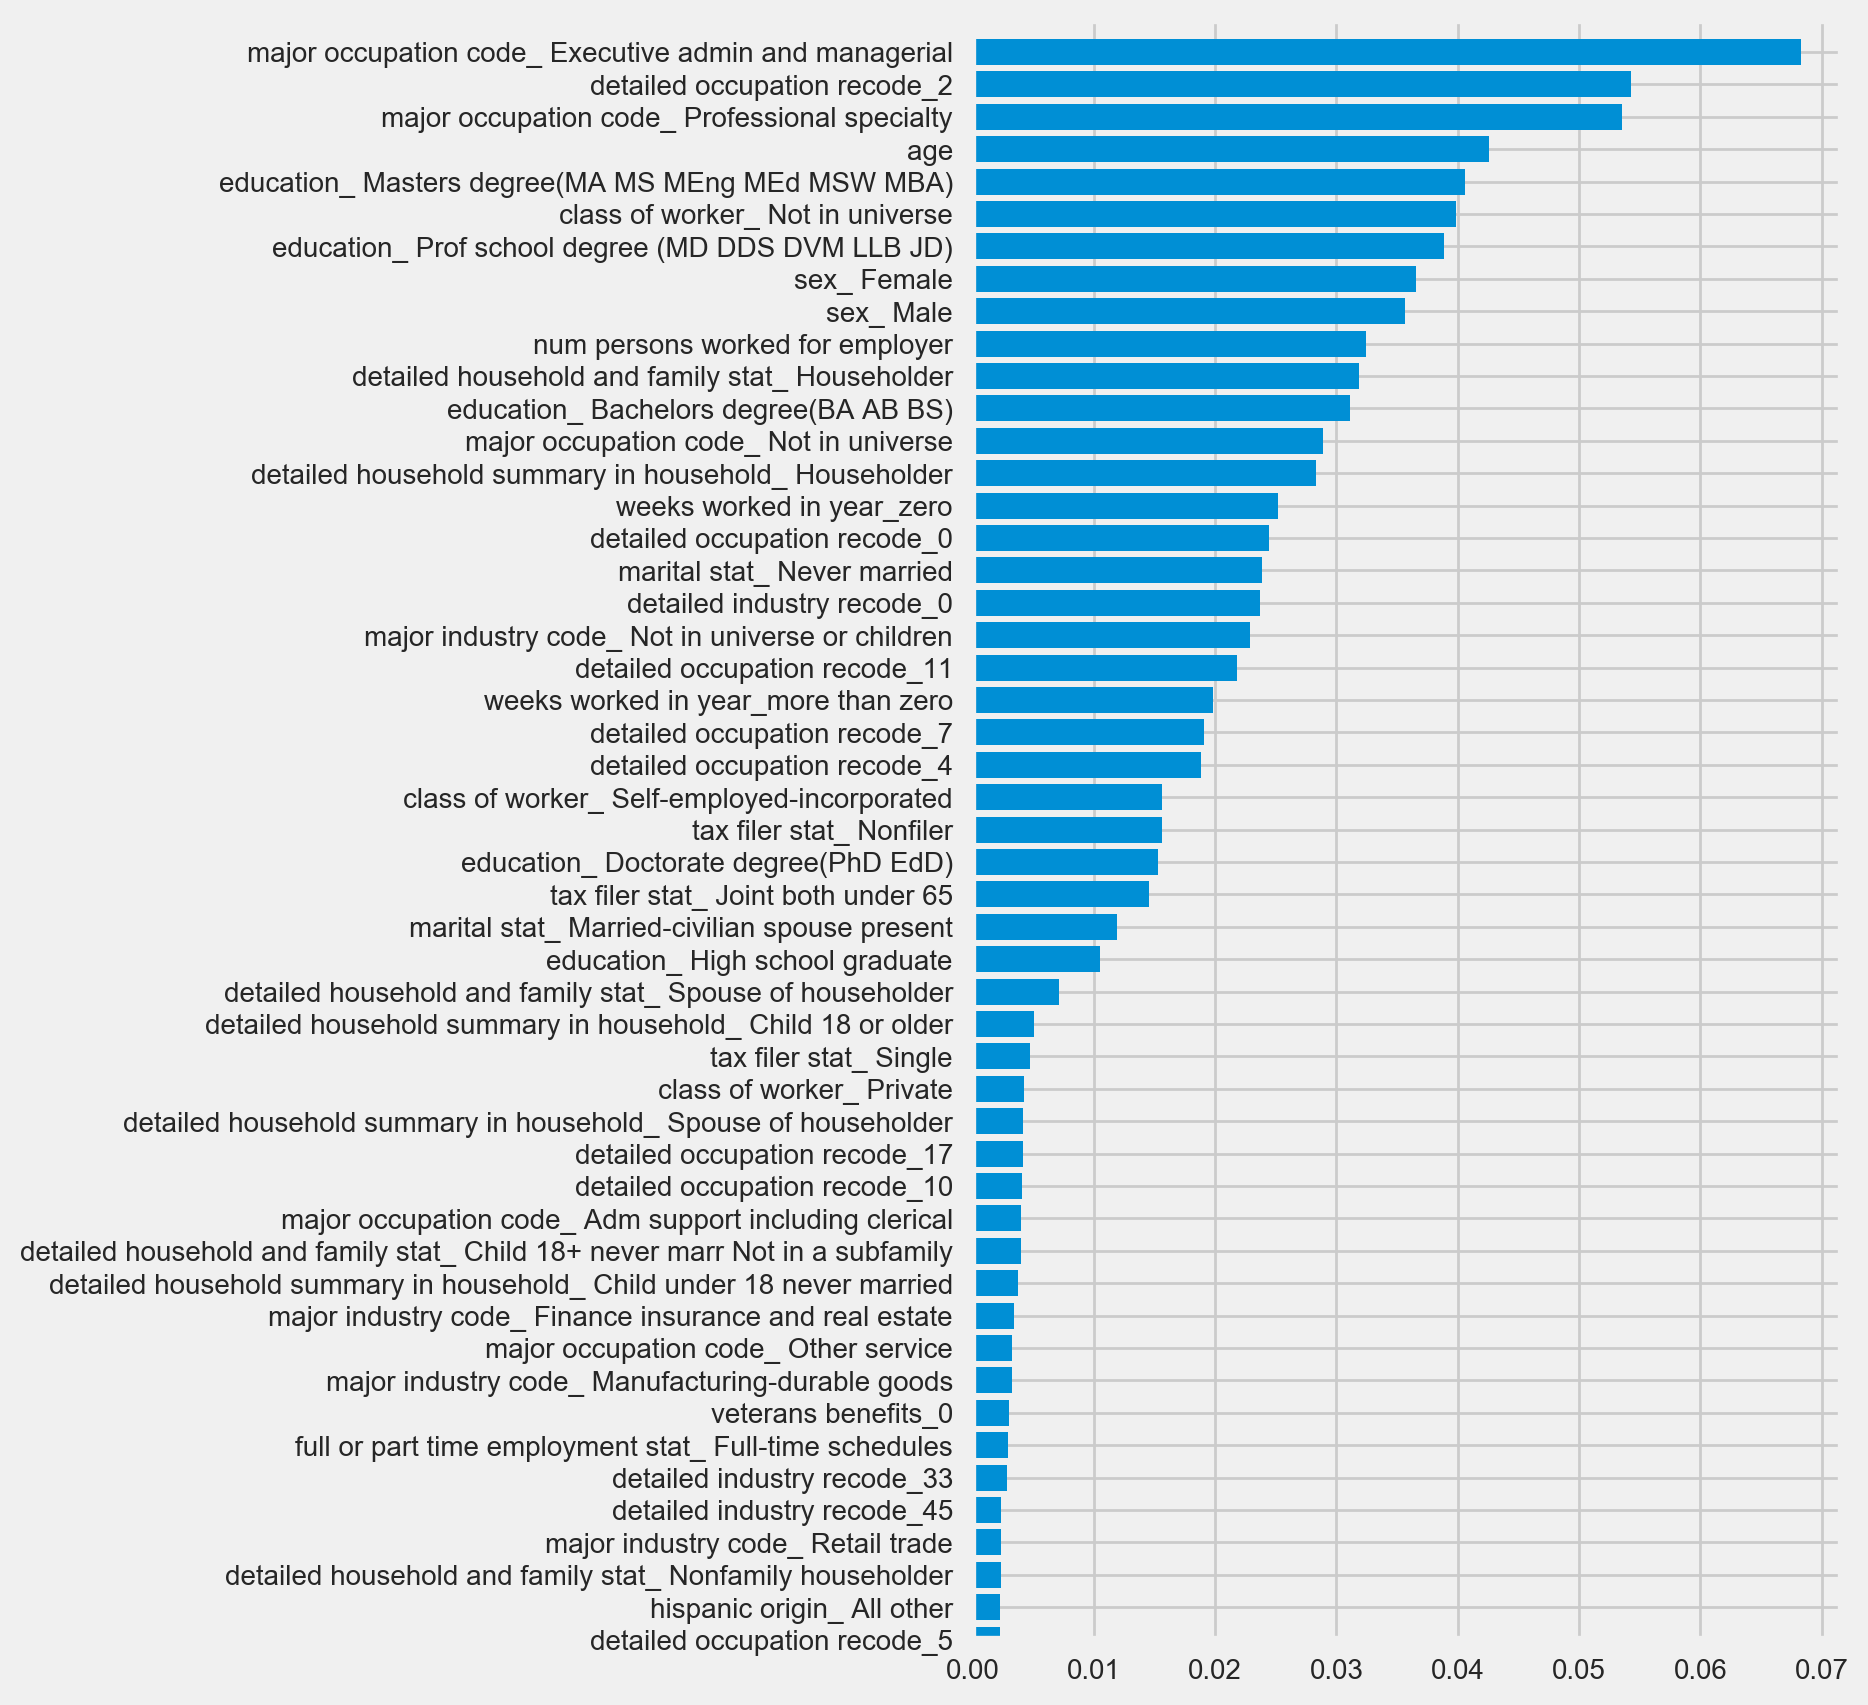

In [32]:
top_n = 50
coef = grid_rf.best_estimator_.feature_importances_
inds = np.argsort(coef)
plt.figure(figsize=(5, 10))
plt.barh(np.arange(top_n), coef[inds[-top_n:]])

plt.yticks(np.arange(top_n), X_train.columns[inds[-top_n:]])
plt.ylim(0, top_n)

### 3.4 Ensembled Model

In [33]:
voting = VotingClassifier([('lr', LogisticRegression(C=1)),
#                            ('dt', DecisionTreeClassifier(max_depth=4)), 
                           ('rf', RandomForestClassifier(n_estimators=100))], 
                          voting='soft')

voting.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))],
         n_jobs=1, voting='soft', weights=None)

In [34]:
print("best test score: {}".format(roc_auc_score(y_test, voting.predict_proba(X_test)[:, 1])))

best test score: 0.9344299251763898
